# 1. 라이브러리, 데이터 불러오기

In [1]:
import os
from typing import List, Dict
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import lightgbm as lgb
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import shap
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from catboost import CatBoostClassifier
from statsmodels.tsa.stattools import ccf
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import xgboost

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 파일 호출
data_path: str = "../data"
train_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "train.csv")).assign(_type="train") # train 에는 _type = train 
test_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")).assign(_type="test") # test 에는 _type = test
submission_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")) # ID, target 열만 가진 데이터 미리 호출
df: pd.DataFrame = pd.concat([train_df, test_df], axis=0)

In [3]:
# HOURLY_ 로 시작하는 .csv 파일 이름을 file_names 에 할딩
file_names: List[str] = [
    f for f in os.listdir(data_path) if f.startswith("HOURLY_") and f.endswith(".csv")
]

# 파일명 : 데이터프레임으로 딕셔너리 형태로 저장
file_dict: Dict[str, pd.DataFrame] = {
    f.replace(".csv", ""): pd.read_csv(os.path.join(data_path, f)) for f in file_names
}

for _file_name, _df in tqdm(file_dict.items()):
    # 열 이름 중복 방지를 위해 {_file_name.lower()}_{col.lower()}로 변경, datetime 열을 ID로 변경
    _rename_rule = {
        col: f"{_file_name.lower()}_{col.lower()}" if col != "datetime" else "ID"
        for col in _df.columns
    }
    _df = _df.rename(_rename_rule, axis=1)
    df = df.merge(_df, on="ID", how="left")


100%|██████████| 107/107 [00:03<00:00, 30.28it/s]


In [4]:
def make_df(df):
    # 모델에 사용할 컬럼, 컬럼의 rename rule을 미리 할당함
    cols_dict: Dict[str, str] = {
        "ID": "ID",
        "target": "target",
        "_type": "_type",
        # coinbase
        "hourly_market-data_coinbase-premium-index_coinbase_premium_gap": "coinbase_premium_gap",
        "hourly_market-data_coinbase-premium-index_coinbase_premium_index": "coinbase_premium_index",
        # funding_rate
        "hourly_market-data_funding-rates_all_exchange_funding_rates": "funding_rates",
        "hourly_market-data_funding-rates_bitmex_funding_rates": "funding_rates",
        
        "hourly_market-data_funding-rates_bitmex_funding_rates": "funding_rates_bitmex",
        # liquidations
        "hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations": "long_liquidations",
        "hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations_usd": "long_liquidations_usd",
        "hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations": "short_liquidations",
        "hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations_usd": "short_liquidations_usd",
        
        "hourly_market-data_liquidations_bybit_all_symbol_long_liquidations": "long_liquidations_bybit",
        "hourly_market-data_liquidations_bybit_all_symbol_short_liquidations": "short_liquidations_bybit",
        "hourly_market-data_liquidations_bitfinex_all_symbol_long_liquidations": "long_liquidations_bitfinex",
        "hourly_market-data_liquidations_bitfinex_all_symbol_short_liquidations": "short_liquidations_bitfinex",
        "hourly_market-data_liquidations_binance_all_symbol_long_liquidations": "long_liquidations_binance",
        "hourly_market-data_liquidations_binance_all_symbol_short_liquidations": "short_liquidations_binance",
        
        # open-interest
        "hourly_market-data_open-interest_all_exchange_all_symbol_open_interest": "open_interest",
        
        # taker_buy_sell
        "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_ratio": "buy_ratio",
        "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_sell_ratio": "buy_sell_ratio",
        "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_volume": "buy_volume",
        "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_ratio": "sell_ratio",
        "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_volume": "sell_volume",
        
        'hourly_market-data_taker-buy-sell-stats_huobi_global_taker_buy_sell_ratio' : "buy_sell_ratio_huobi",
        "hourly_market-data_taker-buy-sell-stats_deribit_taker_buy_volume": "buy_volume_deribit",
        "hourly_market-data_taker-buy-sell-stats_deribit_taker_sell_volume": "sell_volume_deribit",
        "hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_volume": "buy_volume_bybit",
        "hourly_market-data_taker-buy-sell-stats_bybit_taker_sell_volume": "sell_volume_bybit",
        "hourly_market-data_taker-buy-sell-stats_okx_taker_buy_volume": "buy_volume_okx",
        "hourly_market-data_taker-buy-sell-stats_okx_taker_sell_volume": "sell_volume_okx",
        
        # address
        "hourly_network-data_addresses-count_addresses_count_active": "active_count",
        "hourly_network-data_addresses-count_addresses_count_receiver": "receiver_count",
        "hourly_network-data_addresses-count_addresses_count_sender": "sender_count",
        
        # transactions_count
        'hourly_network-data_transactions-count_transactions_count_total' : "transactions_count_total",
        'hourly_network-data_transactions-count_transactions_count_mean' : "transactions_count_mean",
        
        # fees_block
        'hourly_network-data_fees_fees_block_mean' : "block_mean",
        'hourly_network-data_fees_fees_block_mean_usd' : "block_mean_usd",
        
        # fees
        'hourly_network-data_fees_fees_total' : 'fees_total',
        'hourly_network-data_fees_fees_total_usd' : 'fees_total_usd',
        'hourly_network-data_fees_fees_reward_percent' : 'fees_reward_percent',
        
        # difficulty
        'hourly_network-data_difficulty_difficulty' : 'difficulty',
        
        # utxo
        'hourly_network-data_utxo-count_utxo_count' : 'utxo_count',
        
        # supply
        'hourly_network-data_supply_supply_total' : 'supply_total',
        'hourly_network-data_supply_supply_new' : 'supply_new',
        
        # hashrate
        'hourly_network-data_hashrate_hashrate' : 'hashrate',
        
        # fees_transaction
        'hourly_network-data_fees-transaction_fees_transaction_mean' : 'fees_transaction_mean',
        'hourly_network-data_fees-transaction_fees_transaction_mean_usd' : 'fees_transaction_mean_usd',
        'hourly_network-data_fees-transaction_fees_transaction_median' : 'fees_transaction_median',
        'hourly_network-data_fees-transaction_fees_transaction_median_usd' : 'fees_transaction_median_usd',
        
        # blockreward
        'hourly_network-data_blockreward_blockreward' : 'blockreward',
        'hourly_network-data_blockreward_blockreward_usd' : 'blockreward_usd',
        'hourly_network-data_block-interval_block_interval' : 'block_interval',
        
        # transffered_tokens
        'hourly_network-data_tokens-transferred_tokens_transferred_total' : 'tokens_transferred_total',
        'hourly_network-data_tokens-transferred_tokens_transferred_mean' : 'tokens_transferred_mean',
        'hourly_network-data_tokens-transferred_tokens_transferred_median' : 'tokens_transferred_median',
        
        # block_bytes
        'hourly_network-data_block-bytes_block_bytes' : 'block_bytes',
        
        # velocity
        'hourly_network-data_velocity_velocity_supply_total' : 'velocity_supply_total'
        
    }
    df2 = df[cols_dict.keys()].rename(cols_dict, axis=1)
    return df2, cols_dict
    

In [5]:
def feature_engineering(df, cols_dict):
    # eda 에서 파악한 차이와 차이의 음수, 양수 여부를 새로운 피쳐로 생성
    epsilon=1e-6
    df2 = df.assign(
        # liquidation
        liquidation_diff=df["long_liquidations"] - df["short_liquidations"],
        liquidation_diff_bybit=df["long_liquidations_bybit"] - df["short_liquidations_bybit"],
        liquidation_index=(df["long_liquidations"] - df["short_liquidations"])/(df["long_liquidations"] + df["short_liquidations"]+ epsilon),
        liquidation_index_bitfinex=(df["long_liquidations_bitfinex"] - df["short_liquidations_bitfinex"])/(df["long_liquidations_bitfinex"] + df["short_liquidations_bitfinex"]+ epsilon),
        liquidation_index_binance=(df["long_liquidations_binance"] - df["short_liquidations_binance"])/(df["long_liquidations_binance"] + df["short_liquidations_binance"]+ epsilon),
        
        # taker buy sell
        volume_diff=df["buy_volume"] - df["sell_volume"],
        volume_diff_deribit=df["buy_volume_deribit"] - df["sell_volume_deribit"],
        volume_diff_bybit=df["buy_volume_bybit"] - df["sell_volume_bybit"],
        volume_diff_okx=df["buy_volume_okx"] - df["sell_volume_okx"],
        volume_index=(df["buy_volume"] - df["sell_volume"])/(df["buy_volume"] + df["sell_volume"]+ epsilon),
        
        # address
        address_diff = df["sender_count"] - df["receiver_count"],
        
        # interaction term
        buy_sell_volume_ratio=df["buy_volume"] / (df["sell_volume"] + epsilon),
        long_liquidation_interest_ratio = df["long_liquidations"]/df['open_interest'],
        short_liquidation_interest_ratio = df["short_liquidations"]/df['open_interest'],
        long_liquidation_volume_ratio = df["long_liquidations"]/(df['buy_volume']+df['sell_volume']+ epsilon),
        short_liquidation_volume_ratio = df["short_liquidations"]/(df['buy_volume']+df['sell_volume']+ epsilon),
        volume_interest_ratio = (df['buy_volume']+df['sell_volume'])/(df['open_interest']+ epsilon),

        market_pressure = (df['buy_ratio']*df['open_interest']) / (df['sell_ratio']*df['funding_rates']+epsilon),
        network_active = (df['active_count']*df['transactions_count_total'])/(df['block_interval']*df['block_bytes']+epsilon),
        Hodler = (df['utxo_count']*df['difficulty'])/(df['velocity_supply_total']*df['supply_new']+epsilon),
        profitability = (df['blockreward']*df['hashrate'])/(df['difficulty']*df['fees_total']+epsilon),
        investment = df['coinbase_premium_index']*df['tokens_transferred_mean']/(df['tokens_transferred_median']+epsilon),
        leverage = (df['long_liquidations'] + df['short_liquidations'])*df['open_interest']/(df['active_count']*df['tokens_transferred_total']+epsilon),
        fee_index = (df['fees_transaction_mean'] * df['transactions_count_total'])/(df['active_count']*df['supply_new']+epsilon),
        market_health = (df['hashrate']*df['active_count'])/(df['long_liquidations']+df['short_liquidations']+epsilon),
        exchange_center = (df['tokens_transferred_total'] - df['tokens_transferred_mean']*df['transactions_count_total'])/(df['utxo_count']+epsilon),
        
        ## 추가
        hashrate_difficulty_reward_ratio = (df['hashrate'] * df['blockreward']) / (df['difficulty'] * df['fees_total']),
        fees_activity_ratio = df['fees_total'] / (df['active_count'] * df['transactions_count_total']), 
        tokens_fee_ratio = df['tokens_transferred_mean'] / df['fees_transaction_mean'],
        block_interval_difficulty_reward_ratio = (df['blockreward'] / df['block_interval']) * (df['difficulty'] / df['fees_reward_percent']), 
        block_size_transaction_reward_ratio = (df['transactions_count_total'] / df['block_bytes']) * (df['blockreward'] / df['tokens_transferred_total']),
        taker_interest_ratio = (df['buy_volume'] + df['sell_volume']) / df['open_interest'] ,
        premium_liquidation_ratio = df['fees_total'] / (df['difficulty'] * df['utxo_count']),
        velocity_supply_ratio = df['velocity_supply_total'] / (df['supply_total'] * df['transactions_count_mean']),
        funding_taker_ratio = df['buy_sell_ratio'] / df['funding_rates'],

        addresses_count_active_growth_rate = (df['active_count'] - df['active_count'].shift(1)) / df['active_count'].shift(1)


    )
    # category, continuous 열을 따로 할당해둠
    category_cols: List[str] = []
    conti_cols: List[str] = [_ for _ in cols_dict.values() if _ not in ["ID", "target", "_type"]] + [
        "liquidation_diff",
        "liquidation_diff_bybit",
        "liquidation_index",
        "liquidation_index_bitfinex",
        "liquidation_index_binance",
        
        "volume_diff",
        "volume_diff_deribit",
        "volume_diff_bybit",
        "volume_diff_okx",
        "volume_index",
        
        "address_diff",
        
        "buy_sell_volume_ratio",
        "long_liquidation_interest_ratio",
        "short_liquidation_interest_ratio",
        "long_liquidation_volume_ratio",
        "short_liquidation_volume_ratio",
        "volume_interest_ratio",
        
        "market_pressure",
        "network_active",
        "Hodler",
        "profitability",
        "investment",
        "leverage",
        "fee_index",
        "market_health",
        "exchange_center",
    ]
    return df2, category_cols, conti_cols

In [22]:
df2, cols_dict = make_df(df)

In [23]:
train_df = df2[df2._type == 'train'].drop(columns = ['_type', 'target', 'ID'])
test_df= df2[df2._type == 'test'].drop(columns = ['_type', 'target', 'ID'])

# 2. 결측치 처리

In [24]:
temp = train_df.copy()

iimp = IterativeImputer(
estimator = xgboost.XGBRegressor(),
random_state = 42,
verbose = 2,
max_iter=15
)

final = iimp.fit_transform(train_df)

[IterativeImputer] Completing matrix with shape (8760, 54)
[IterativeImputer] Ending imputation round 1/15, elapsed time 23.15
[IterativeImputer] Change: 15882020652404.398, scaled tolerance: 72006146478.5671 
[IterativeImputer] Ending imputation round 2/15, elapsed time 47.34
[IterativeImputer] Change: 520794222662.88983, scaled tolerance: 72006146478.5671 
[IterativeImputer] Ending imputation round 3/15, elapsed time 72.02
[IterativeImputer] Change: 235141245206.2908, scaled tolerance: 72006146478.5671 
[IterativeImputer] Ending imputation round 4/15, elapsed time 95.00
[IterativeImputer] Change: 358940148733.0492, scaled tolerance: 72006146478.5671 
[IterativeImputer] Ending imputation round 5/15, elapsed time 118.82
[IterativeImputer] Change: 356402674682.4908, scaled tolerance: 72006146478.5671 
[IterativeImputer] Ending imputation round 6/15, elapsed time 142.26
[IterativeImputer] Change: 576049998479.4775, scaled tolerance: 72006146478.5671 
[IterativeImputer] Ending imputation 

/opt/conda/lib/python3.10/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [25]:
final2 = iimp.transform(test_df)

train_df = pd.DataFrame(final, columns = train_df.columns)
test_df = pd.DataFrame(final2, columns = test_df.columns)
df3 = pd.concat([train_df, test_df], axis = 0).reset_index(drop=True)
df3[['ID', 'target','_type']] = df[['ID', 'target','_type']] 

[IterativeImputer] Completing matrix with shape (2792, 54)
[IterativeImputer] Ending imputation round 1/15, elapsed time 0.04
[IterativeImputer] Ending imputation round 2/15, elapsed time 0.09
[IterativeImputer] Ending imputation round 3/15, elapsed time 0.13
[IterativeImputer] Ending imputation round 4/15, elapsed time 0.18
[IterativeImputer] Ending imputation round 5/15, elapsed time 0.23
[IterativeImputer] Ending imputation round 6/15, elapsed time 0.27
[IterativeImputer] Ending imputation round 7/15, elapsed time 0.32
[IterativeImputer] Ending imputation round 8/15, elapsed time 0.36
[IterativeImputer] Ending imputation round 9/15, elapsed time 0.41
[IterativeImputer] Ending imputation round 10/15, elapsed time 0.46
[IterativeImputer] Ending imputation round 11/15, elapsed time 0.50
[IterativeImputer] Ending imputation round 12/15, elapsed time 0.55
[IterativeImputer] Ending imputation round 13/15, elapsed time 0.60
[IterativeImputer] Ending imputation round 14/15, elapsed time 0.6

# 3. 변수 정리

In [26]:
# 파생 변수 생성에만 필요했던 변수들은 제거
drop_cols1 = ['long_liquidations_bybit', 'short_liquidations_bybit', 
             'long_liquidations_bitfinex', 'short_liquidations_bitfinex', 
             'long_liquidations_binance', 'short_liquidations_binance',
             'buy_volume_deribit', 'sell_volume_deribit',
             'buy_volume_bybit', 'sell_volume_bybit',
             'buy_volume_okx', 'sell_volume_okx',
             ]

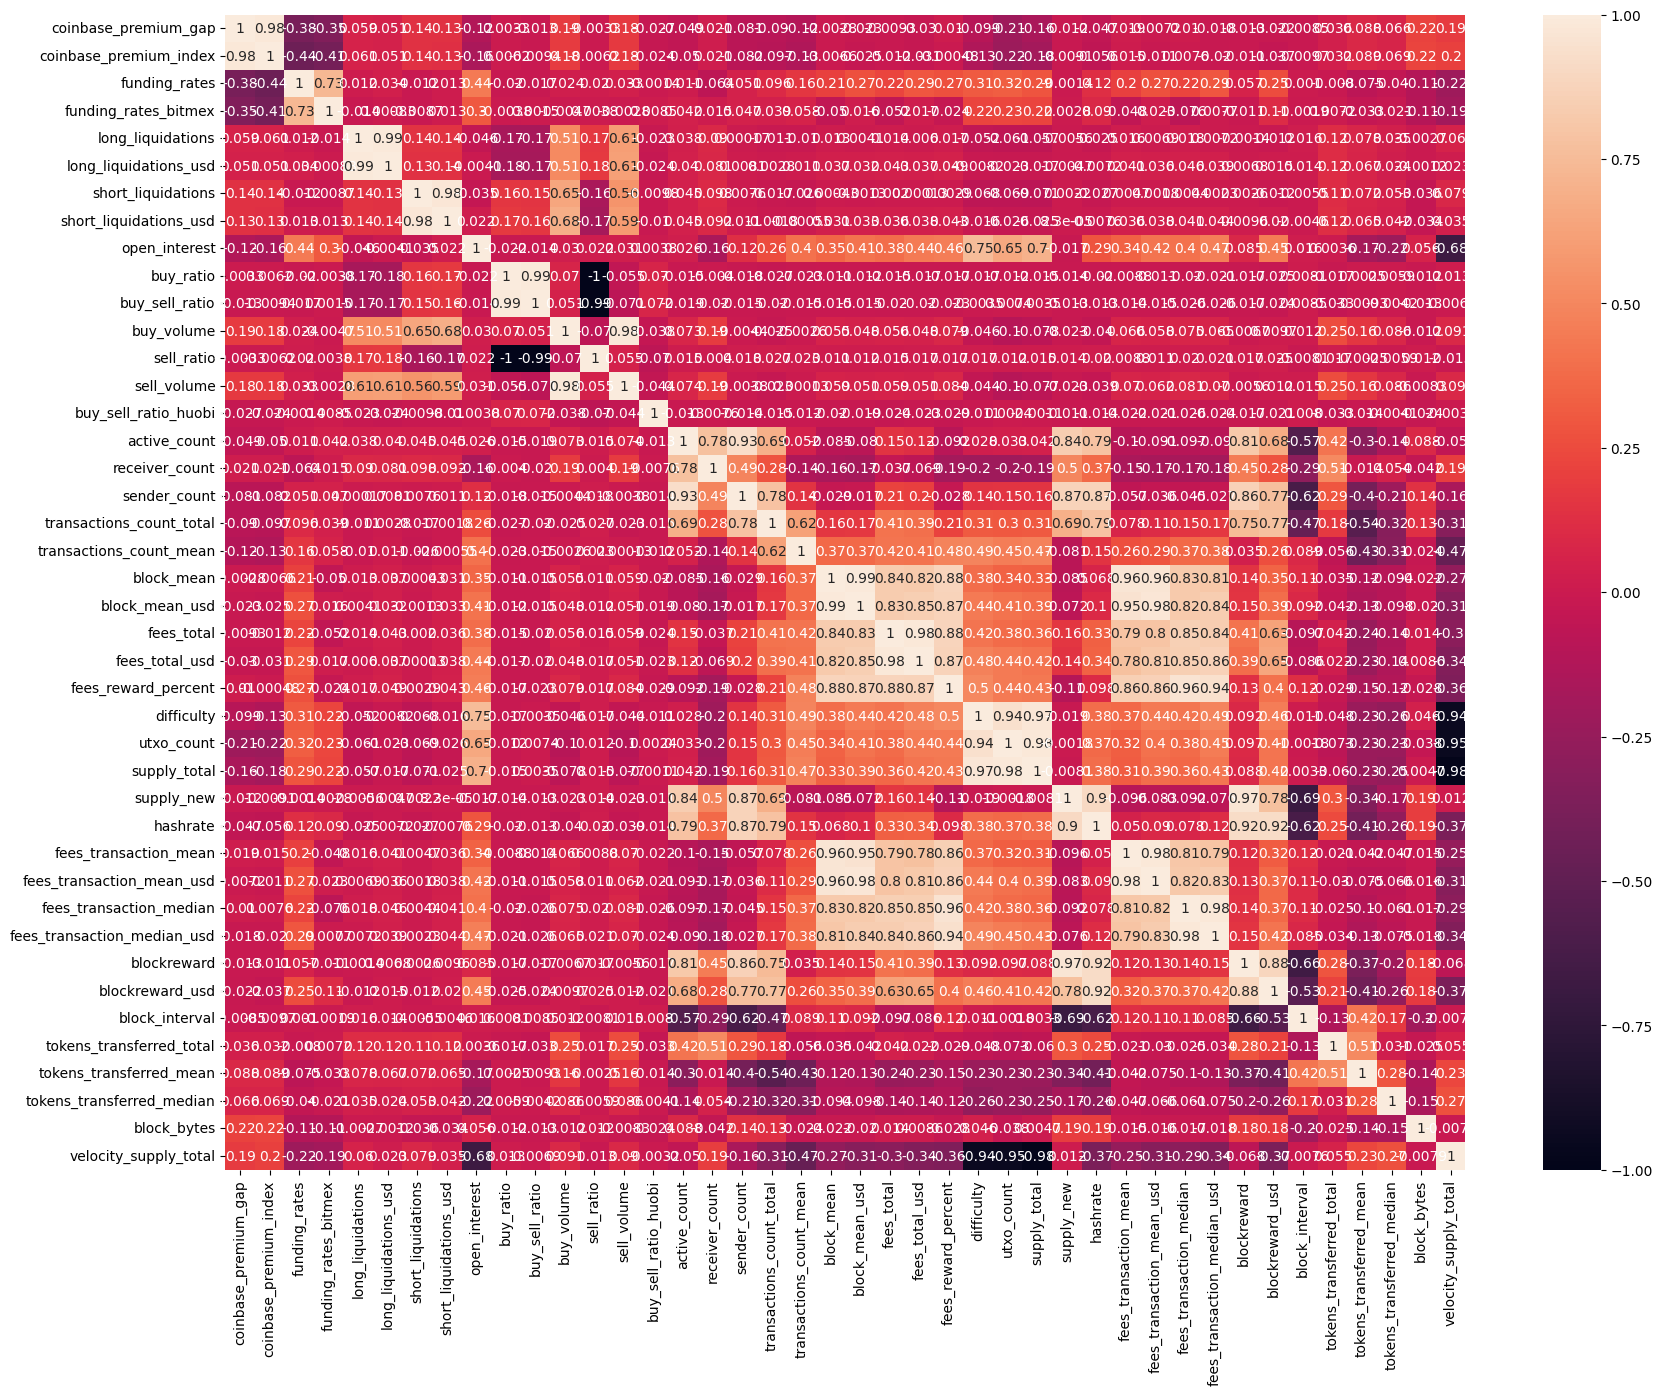

In [27]:
x = df3[df3.ID < '2024-01-01'].drop(columns = ['target', 'ID', '_type']+drop_cols1)
corr_matrix = x.corr('pearson')

plt.figure(figsize = (20,15))
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [28]:
# 제거할 변수 (corr 0.9 이상)
drop_cols2 = [
    'coinbase_premium_gap', 
    'long_liquidations_usd', 'short_liquidations_usd', 
    'buy_sell_ratio', 'sell_ratio', 'sell_volume',
    'block_mean', 'block_mean_usd', 'blockreward',
    'fees_total', 'fees_transaction_mean', 'fees_transaction_median', 
    'supply_total', 'utxo_count', 'supply_new', 'velocity_supply_total', 'fees_reward_percent', 'hashrate', 'sender_count'
]

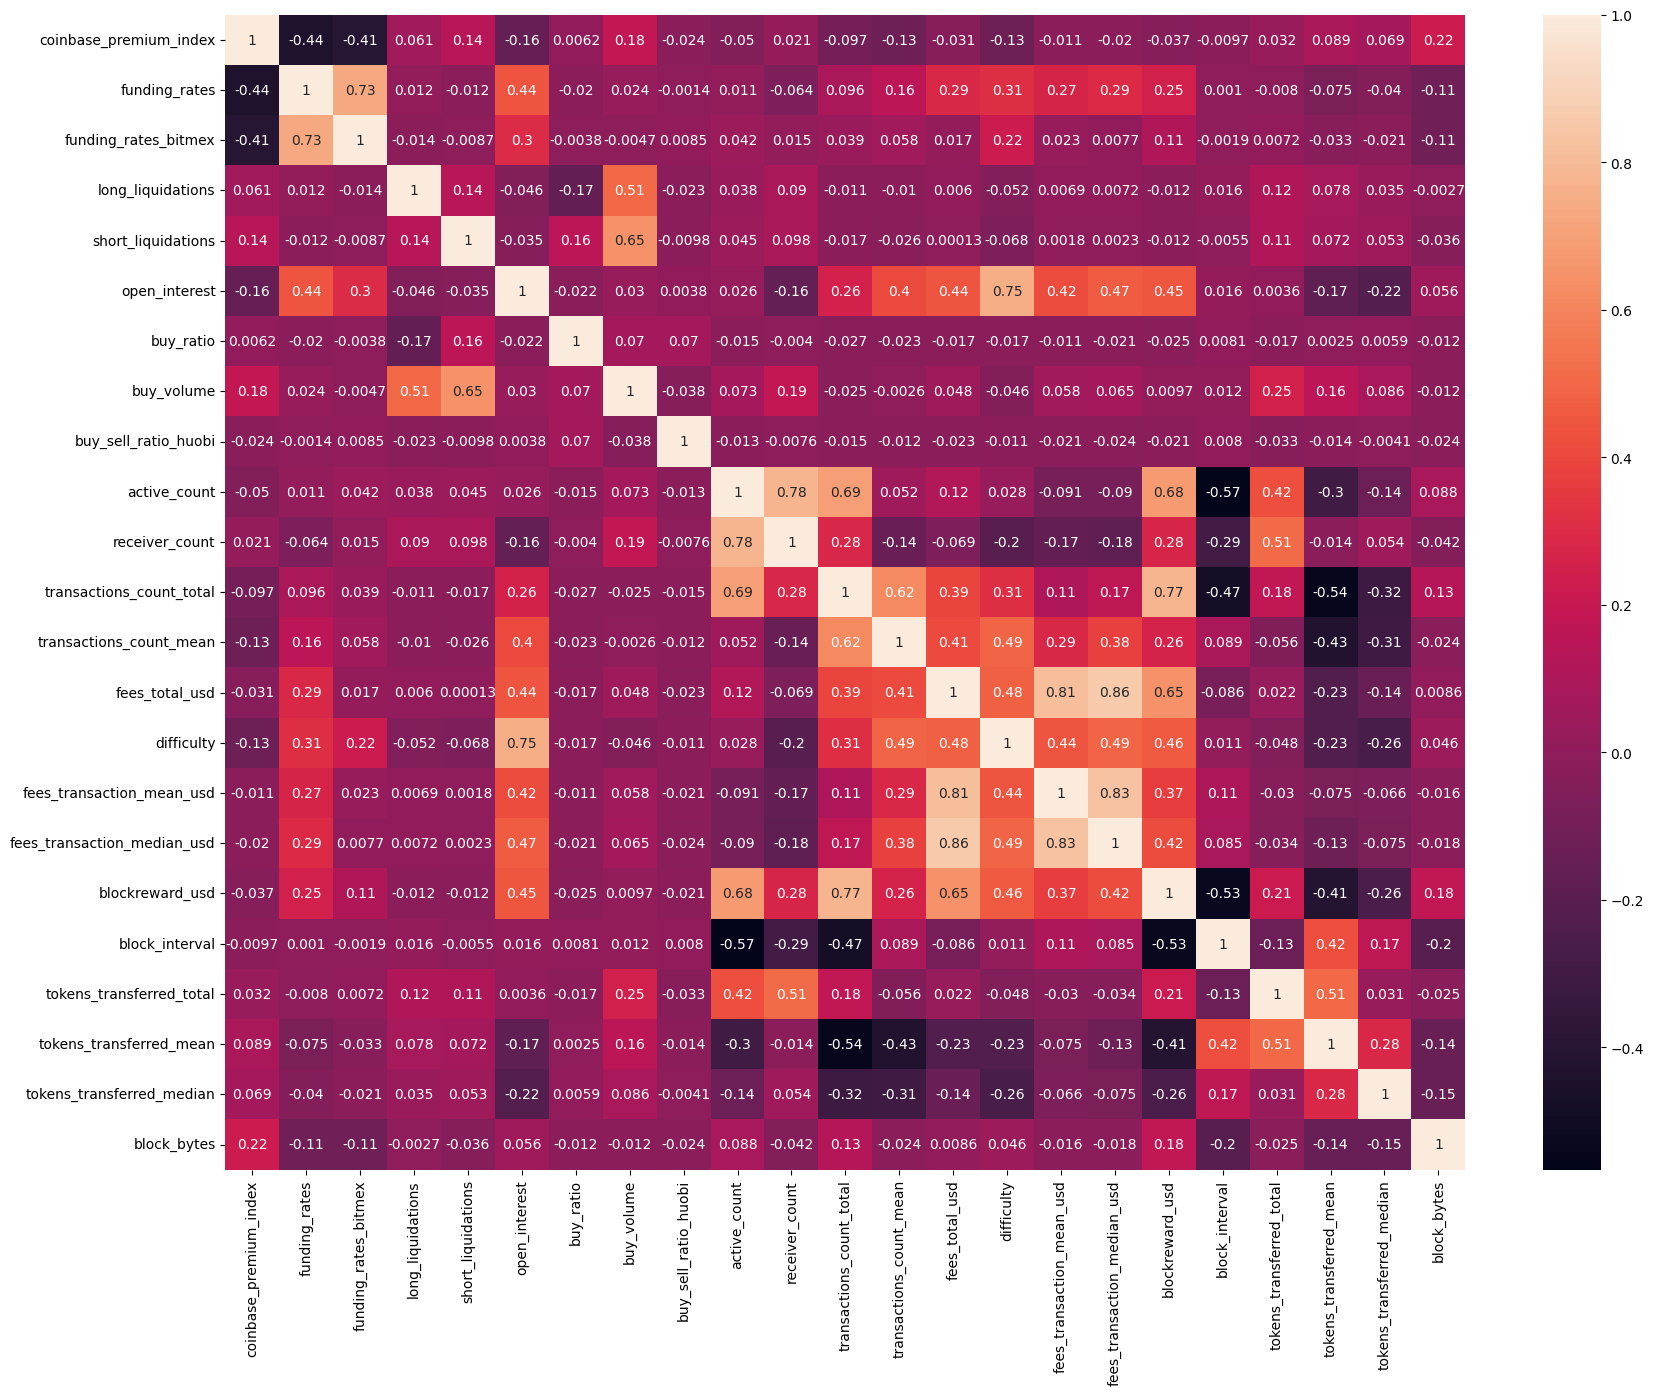

In [29]:
x = df3[df3.ID < '2024-01-01'].drop(columns = ['target', 'ID', '_type']+ drop_cols1 + drop_cols2)
corr_matrix = x.corr('pearson')

plt.figure(figsize = (20,15))
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [30]:
# 파생변수 생성
df3, category_cols, conti_cols = feature_engineering(df3, cols_dict)

In [31]:
# 파생 변수 중에 corr 0.0 이상 제거
drop_cols3 = ['long_liquidation_interest_ratio', 'short_liquidation_interest_ratio', 
              'volume_interest_ratio', 'buy_sell_volume_ratio', 'volume_index','taker_interest_ratio',
              'hashrate_difficulty_reward_ratio', 'fees_activity_ratio', 'block_interval_difficulty_reward_ratio'
              ]

In [32]:
df3['ID_dt'] = pd.to_datetime(df3['ID'])

df3['D'] = df3['ID_dt'].dt.day
df3['H'] = df3['ID_dt'].dt.hour

df3['Is_Afternoon_Evening'] = df3['H'].apply(lambda x: 1 if 12 <= x <= 20 else 0)
df3['Is_Weekend'] = df3['ID_dt'].dt.weekday.apply(lambda x: 1 if x >= 5 else 0)

df3 = df3.drop(['ID_dt','D','H'],axis=1)

In [33]:
# 최종 변수 제거
drop_cols = drop_cols1 + drop_cols2 + drop_cols3
df_select = df3.drop(columns = drop_cols)

In [34]:
df_select

,coinbase_premium_index,funding_rates,funding_rates_bitmex,long_liquidations,short_liquidations,open_interest,buy_ratio,buy_volume,buy_sell_ratio_huobi,active_count,...,market_health,exchange_center,tokens_fee_ratio,block_size_transaction_reward_ratio,premium_liquidation_ratio,velocity_supply_ratio,funding_taker_ratio,addresses_count_active_growth_rate,Is_Afternoon_Evening,Is_Weekend
0,-0.059650,0.005049,0.001400,0.012000,0.000000,6.271344e+09,0.475003,4.648309e+07,4.046784,67987.0,...,2.868199e+18,-4.986310e-13,58919.999796,0.000033,1.904329e-22,3.590163e-09,179.185118,NaN,0,1
1,-0.053047,0.005049,0.001400,0.000000,0.712000,6.288683e+09,0.623454,3.975599e+07,14.473239,30593.0,...,7.251386e+15,1.434318e-13,50472.421939,0.000013,8.697117e-23,2.350919e-09,327.913566,-0.550017,0,1
2,-0.057952,0.005049,0.001400,0.000000,0.000000,6.286796e+09,0.506785,2.405402e+07,3.529514,33897.0,...,1.144118e+22,3.011496e-13,86144.754921,0.000019,1.062265e-22,4.940566e-09,203.527463,0.107999,0,1
3,-0.058912,0.005067,0.001518,0.593000,0.000000,6.284575e+09,0.466518,2.860215e+07,6.477528,32717.0,...,1.163878e+16,2.271793e-13,148977.480315,0.000008,7.460023e-23,3.267386e-09,172.589934,-0.034811,0,1
4,-0.061373,0.006210,0.008400,0.361000,0.000000,6.291582e+09,0.491559,3.087720e+07,0.711501,45176.0,...,3.695872e+16,5.027650e-14,76986.516908,0.000016,1.170144e-22,3.455840e-09,155.678459,0.380811,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11547,-0.002376,0.038292,0.009616,0.710000,0.243500,1.486836e+10,0.499913,2.681646e+08,0.451684,29250.0,...,9.673417e+15,2.435759e-13,14477.895478,0.000002,1.476944e-22,2.394949e-10,26.110847,-0.249846,0,0
11548,-0.018268,0.044642,0.015465,6.577208,0.146000,1.036679e+10,0.499913,2.663238e+08,1.605582,56580.0,...,5.307519e+15,-1.303028e-04,12761.773905,0.000006,2.553249e-22,1.646967e-10,22.390627,0.934359,0,0
11549,0.002866,0.048401,0.017206,1.797163,5.216490,1.078753e+10,0.500765,2.685918e+08,0.783058,51858.0,...,4.663120e+15,-1.915257e-05,5933.135152,0.000015,2.367899e-22,1.552759e-10,20.701829,-0.083457,0,0
11550,-0.003184,0.039396,0.014390,0.803000,1.656000,1.080558e+10,0.499816,2.691089e+08,1.771881,36270.0,...,6.201586e+15,-1.536108e-05,17173.614365,0.000004,1.225522e-22,1.944262e-10,25.382485,-0.300590,0,0


# 4. PCA

In [36]:
train_df = df_select[df_select._type == 'train'].drop(columns = '_type')
test_df = df_select[df_select._type == 'test'].drop(columns = '_type')

## (1) 주성분 개수 정하기
- 차원 개수 결정 : 누적 설명 분산 비율
- PCA를 수행 → 각 주성분이 설명하는 분산 비율을 확인하고, 누적 설명 분산 비율을 계산 → 원하는 비율(예 90%)에 도달할 때까지 주성분을 선택하는 방법

/tmp/ipykernel_635653/109926804.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X.fillna(X.mean(), inplace=True)


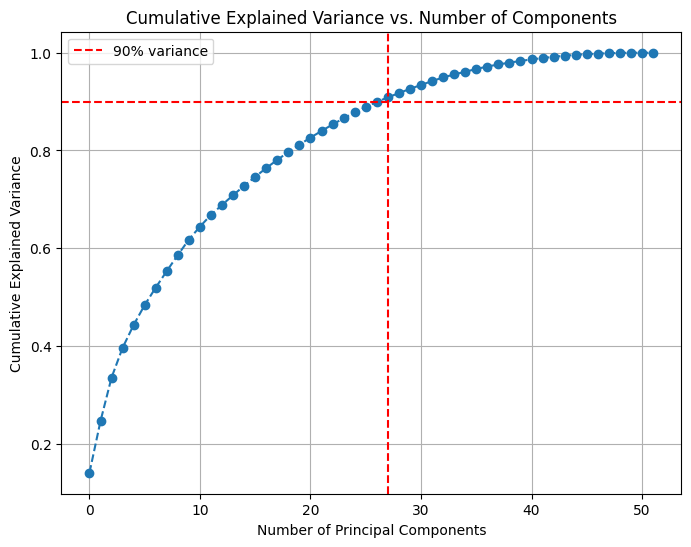

Principal Component 1: Cumulative Explained Variance = 0.1403
Principal Component 2: Cumulative Explained Variance = 0.2461
Principal Component 3: Cumulative Explained Variance = 0.3352
Principal Component 4: Cumulative Explained Variance = 0.3961
Principal Component 5: Cumulative Explained Variance = 0.4428
Principal Component 6: Cumulative Explained Variance = 0.4837
Principal Component 7: Cumulative Explained Variance = 0.5194
Principal Component 8: Cumulative Explained Variance = 0.5532
Principal Component 9: Cumulative Explained Variance = 0.5861
Principal Component 10: Cumulative Explained Variance = 0.6176
Principal Component 11: Cumulative Explained Variance = 0.6441
Principal Component 12: Cumulative Explained Variance = 0.6683
Principal Component 13: Cumulative Explained Variance = 0.6886
Principal Component 14: Cumulative Explained Variance = 0.7085
Principal Component 15: Cumulative Explained Variance = 0.7277
Principal Component 16: Cumulative Explained Variance = 0.7460
P

In [37]:
# 1. 데이터 준비 (df_select에서 수치형 데이터만 선택)
X = train_df.drop('target',axis=1).select_dtypes(include=[float, int])
X.replace([float('inf'), float('-inf')], pd.NA, inplace=True)
X.fillna(X.mean(), inplace=True)

# 2. 데이터 스케일링 (PCA 전에 스케일링은 필수)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. PCA 모델 생성 및 데이터에 적용
pca = PCA()  # 주성분 개수를 지정하지 않고 전체를 사용
pca.fit(X_scaled)

# 4. 누적 설명 분산 비율 계산
cumulative_variance = pca.explained_variance_ratio_.cumsum()

# 5. 누적 설명 분산 비율을 그래프로 시각화
plt.figure(figsize=(8, 6))
plt.plot(cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Components')

# 6. 누적 설명 분산 비율이 90%에 도달하는 곳에 수평선 추가
plt.axhline(y=0.90, color='r', linestyle='--', label='90% variance')
plt.axvline(x=(cumulative_variance >= 0.90).argmax(), color='r', linestyle='--')  # 90%에 도달하는 지점
plt.legend(loc='best')
plt.grid(True)
plt.show()

# 7. 설명된 분산 비율을 프린트 (선택 사항)
for i, variance in enumerate(cumulative_variance):
    print(f"Principal Component {i+1}: Cumulative Explained Variance = {variance:.4f}")

# 8. 90%에 도달하는 주성분 개수 계산
num_components_90 = (cumulative_variance >= 0.90).argmax() + 1
print(f"90% 누적 설명 분산 비율에 도달하는 주성분의 개수: {num_components_90}")


## (2) PCA

In [39]:
# 트레인과 테스트 데이터 준비 (가정: train_df, test_df)
X_train = train_df.drop('target',axis=1).select_dtypes(include=[float, int])
X_test = test_df.drop('target',axis=1).select_dtypes(include=[float, int])

# 무한대 및 NaN 값 처리
X_train.replace([float('inf'), float('-inf')], pd.NA, inplace=True)
X_test.replace([float('inf'), float('-inf')], pd.NA, inplace=True)
X_train.fillna(X_train.mean(), inplace=True)
X_test.fillna(X_test.mean(), inplace=True)

# 데이터 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # 트레인 데이터 스케일링
X_test_scaled = scaler.transform(X_test)  # 테스트 데이터 스케일링 (fit이 아닌 transform만)

# PCA 모델 생성 및 트레인 데이터에 적합
pca = PCA(n_components=28)
X_train_pca = pca.fit_transform(X_train_scaled)  # 트레인 데이터에 PCA 적용

# 테스트 데이터에 PCA 변환 적용
X_test_pca = pca.transform(X_test_scaled)  # 테스트 데이터에 PCA 적용

# PCA 결과를 데이터프레임으로 변환
pca_train_df = pd.DataFrame(data=X_train_pca, columns=[f'PC{i+1}' for i in range(28)])
pca_test_df = pd.DataFrame(data=X_test_pca, columns=[f'PC{i+1}' for i in range(28)])

# 결과 확인
print(pca_train_df.head())
print(pca_test_df.head())


        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -3.246593 -1.060506  3.993831 -1.052320 -1.510954  3.920348  3.087378   
1 -4.242344  1.531324 -0.391962 -1.751620 -0.877540  1.861153  1.762433   
2 -5.419515 -0.181973  2.247102 -1.475482 -1.713839  4.975635  3.789977   
3 -6.011601 -1.298299  0.905075 -0.379075 -0.573651  4.094699  2.198127   
4 -4.712630 -1.055610  1.568022 -0.664683 -0.873327  3.610322  2.329974   

        PC8       PC9      PC10  ...      PC19      PC20      PC21      PC22  \
0 -0.271798  0.612779  1.560825  ...  0.418142 -0.234645 -0.086067 -1.270101   
1 -1.158587  0.569165 -1.920622  ...  0.115980  0.353427  0.314893  0.219411   
2 -0.977920  0.828339  0.637877  ...  0.301829 -0.133628 -0.708595 -0.434511   
3  0.172576  0.300209  1.648275  ...  0.861834 -0.667469  0.085281  0.298530   
4  0.089702  0.422545  1.391028  ...  1.218517 -0.329844 -0.088712 -0.402555   

       PC23      PC24      PC25      PC26      PC27      PC28  
0  0

/tmp/ipykernel_635653/2295635131.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_train.fillna(X_train.mean(), inplace=True)
/tmp/ipykernel_635653/2295635131.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_test.fillna(X_test.mean(), inplace=True)


## (3) 각 성분 보기

      coinbase_premium_index  funding_rates  funding_rates_bitmex  \
PC1                -0.052486       0.118872              0.046496   
PC2                 0.022974      -0.000892              0.005508   
PC3                 0.010845      -0.094549             -0.028730   
PC4                 0.093348       0.023668             -0.022715   
PC5                -0.376165       0.405124              0.483060   
PC6                -0.142509       0.165075              0.086955   
PC7                -0.142613       0.264404              0.218448   
PC8                 0.017542      -0.112470             -0.099049   
PC9                -0.027048       0.052959              0.050231   
PC10               -0.016366       0.085470              0.087936   
PC11                0.229880       0.000054              0.002002   
PC12               -0.141113      -0.182624             -0.205211   
PC13               -0.176591       0.021477              0.025454   
PC14                0.055270      

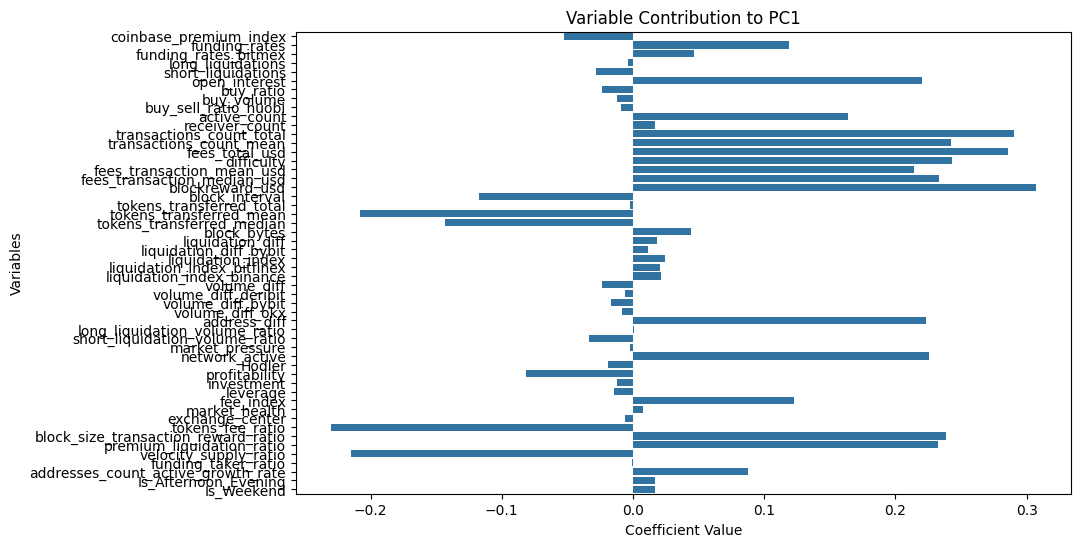

In [40]:
# PCA 모델 생성 및 트레인 데이터에 적합
pca = PCA(n_components=28)
X_train_pca = pca.fit_transform(X_train_scaled)

# 1. 주성분의 계수 확인
components = pca.components_

# 2. 원래 변수 이름과 주성분 계수를 데이터프레임으로 변환
components_df = pd.DataFrame(components, columns=X_train.columns, index=[f'PC{i+1}' for i in range(28)])

# 3. 주성분과 변수의 관계 출력
print(components_df)

# 4. 특정 주성분에 대한 변수 기여도 시각화 (예: 첫 번째 주성분)
plt.figure(figsize=(10, 6))
sns.barplot(x=components_df.loc['PC1'], y=components_df.columns)
plt.title('Variable Contribution to PC1')
plt.xlabel('Coefficient Value')
plt.ylabel('Variables')
plt.show()


## (4) 합치기 & 시각화

In [41]:
additional_info_df = df_select[['ID', '_type', 'target']]

combined_pca_df = pd.concat([pca_train_df, pca_test_df], ignore_index=True)

final_df = pd.concat([additional_info_df.reset_index(drop=True), combined_pca_df], axis=1)

final_df


,ID,_type,target,PC1,PC2,PC3,PC4,PC5,PC6,PC7,...,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28
0,2023-01-01 00:00:00,train,2.0,-3.246593,-1.060506,3.993831,-1.052320,-1.510954,3.920348,3.087378,...,0.418142,-0.234645,-0.086067,-1.270101,0.595035,-0.726989,0.422876,0.588324,0.325999,0.022088
1,2023-01-01 01:00:00,train,1.0,-4.242344,1.531324,-0.391962,-1.751620,-0.877540,1.861153,1.762433,...,0.115980,0.353427,0.314893,0.219411,0.678077,-0.601016,0.482663,-0.624657,1.393501,0.331016
2,2023-01-01 02:00:00,train,1.0,-5.419515,-0.181973,2.247102,-1.475482,-1.713839,4.975635,3.789977,...,0.301829,-0.133628,-0.708595,-0.434511,0.701815,-0.901453,1.086741,0.370909,0.501862,-0.404785
3,2023-01-01 03:00:00,train,1.0,-6.011601,-1.298299,0.905075,-0.379075,-0.573651,4.094699,2.198127,...,0.861834,-0.667469,0.085281,0.298530,0.662869,-0.963195,0.562214,0.279974,-0.025464,0.064378
4,2023-01-01 04:00:00,train,2.0,-4.712630,-1.055610,1.568022,-0.664683,-0.873327,3.610322,2.329974,...,1.218517,-0.329844,-0.088712,-0.402555,0.697506,-0.798467,0.641678,0.258886,0.528290,0.160930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11547,2024-04-26 03:00:00,test,NaN,2.544722,-0.979374,-4.973900,-0.490427,3.311442,0.459491,-0.089272,...,0.868037,-0.059659,0.011733,-1.585968,1.069650,1.796983,1.966768,-0.101622,0.619715,-0.312068
11548,2024-04-26 04:00:00,test,NaN,4.198767,-1.717340,-1.811713,1.284649,4.064498,0.943599,-0.087925,...,4.779617,1.663556,4.076956,1.992074,0.864647,2.518814,0.213735,2.635954,1.612134,1.050302
11549,2024-04-26 05:00:00,test,NaN,4.249161,-0.284084,-2.626121,-0.921262,3.310391,-0.229260,0.434745,...,0.777891,0.339139,0.959647,0.114685,1.211551,3.148374,1.943172,1.157002,0.807278,0.367019
11550,2024-04-26 06:00:00,test,NaN,2.280598,0.397916,-3.146428,-1.085702,2.976153,-0.245597,-0.165897,...,0.850345,0.626665,0.094979,-0.527347,0.172356,-1.558156,-1.600761,0.033876,0.174663,0.233987


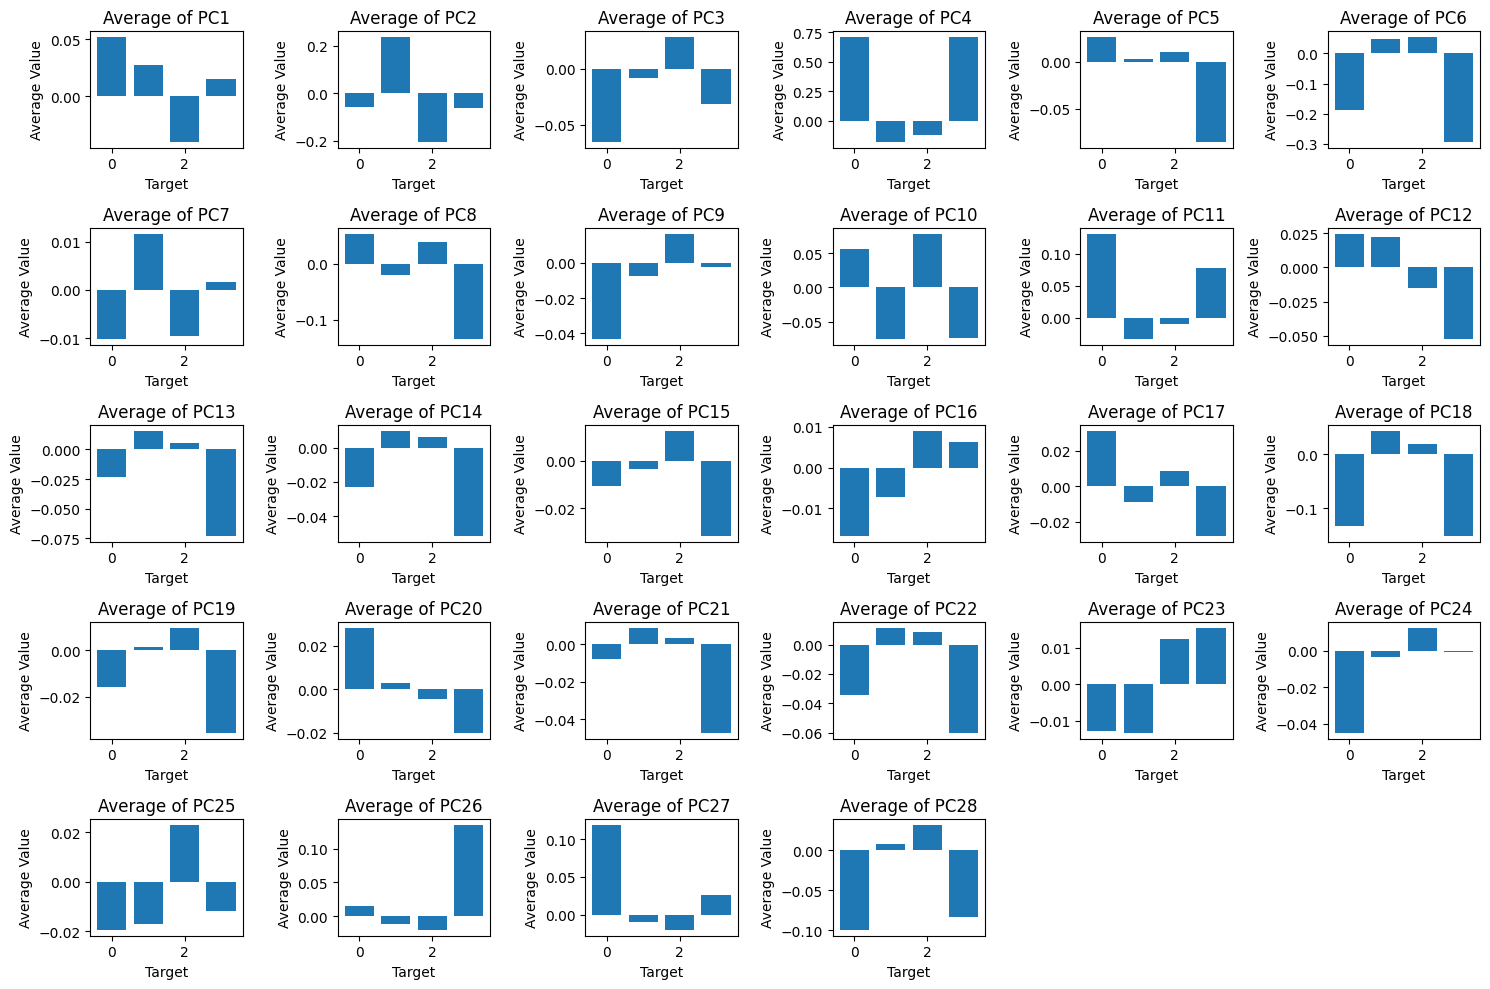

In [42]:
pca_means = final_df[final_df['_type']=='train'].iloc[:, 2:].groupby('target').mean()  

plt.figure(figsize=(15, 10))

for i in range(1, 29):  
    plt.subplot(5, 6, i)  
    plt.bar(pca_means.index, pca_means[f'PC{i}'])
    plt.title(f'Average of PC{i}')
    plt.xlabel('Target')
    plt.ylabel('Average Value')

plt.tight_layout()  
plt.show()


In [43]:
train_df = final_df[final_df._type == 'train'].drop(columns = '_type')
test_df = final_df[final_df._type == 'test'].drop(columns = '_type')

In [44]:
def create_ccf_grid_plot(data, y_var, x_vars, max_lag=120):
    n_vars = len(x_vars)
    n_cols = 3
    n_rows = (n_vars + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
    fig.suptitle(f'Backward CCF Plots: {y_var} vs Other Variables (Last {max_lag} hours)', fontsize=16)

    for i, x_var in enumerate(x_vars):
        row = i // n_cols
        col = i % n_cols
        ax = axes[row, col] if n_rows > 1 else axes[col]

        y = data[y_var]
        x = data[x_var]
        
        # ccf value
        ccf_values = ccf(x[::-1], y[::-1], adjusted=False, nlags = max_lag) # backward corr 계산을 위해 [::-1]로 reverse
        lags = range(0,max_lag) 
    
        ax.bar(lags, ccf_values, width=0.3)
        ax.axhline(y=0, color='black', linestyle='-')
        ax.axhline(y=1.96/np.sqrt(max_lag), color='r', linestyle='--')
        ax.axhline(y=-1.96/np.sqrt(max_lag), color='r', linestyle='--')
        
        ax.set_title(f'{y_var} vs {x_var}')
        ax.set_xlabel('Lag (hours)')
        ax.set_ylabel('Cross-Correlation')
        ax.tick_params(axis='x', rotation=45)

    # Remove empty subplots
    for i in range(n_vars, n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        fig.delaxes(axes[row, col] if n_rows > 1 else axes[col])

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    return fig

In [45]:
train_df.head(3)

,ID,target,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,...,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28
0,2023-01-01 00:00:00,2.0,-3.246593,-1.060506,3.993831,-1.052320,-1.510954,3.920348,3.087378,-0.271798,...,0.418142,-0.234645,-0.086067,-1.270101,0.595035,-0.726989,0.422876,0.588324,0.325999,0.022088
1,2023-01-01 01:00:00,1.0,-4.242344,1.531324,-0.391962,-1.751620,-0.877540,1.861153,1.762433,-1.158587,...,0.115980,0.353427,0.314893,0.219411,0.678077,-0.601016,0.482663,-0.624657,1.393501,0.331016
2,2023-01-01 02:00:00,1.0,-5.419515,-0.181973,2.247102,-1.475482,-1.713839,4.975635,3.789977,-0.977920,...,0.301829,-0.133628,-0.708595,-0.434511,0.701815,-0.901453,1.086741,0.370909,0.501862,-0.404785


# 5. CCF plot

In [46]:
train2 = train_df.copy()
train2['close'] = df[df['_type']=='train']['hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close'].values


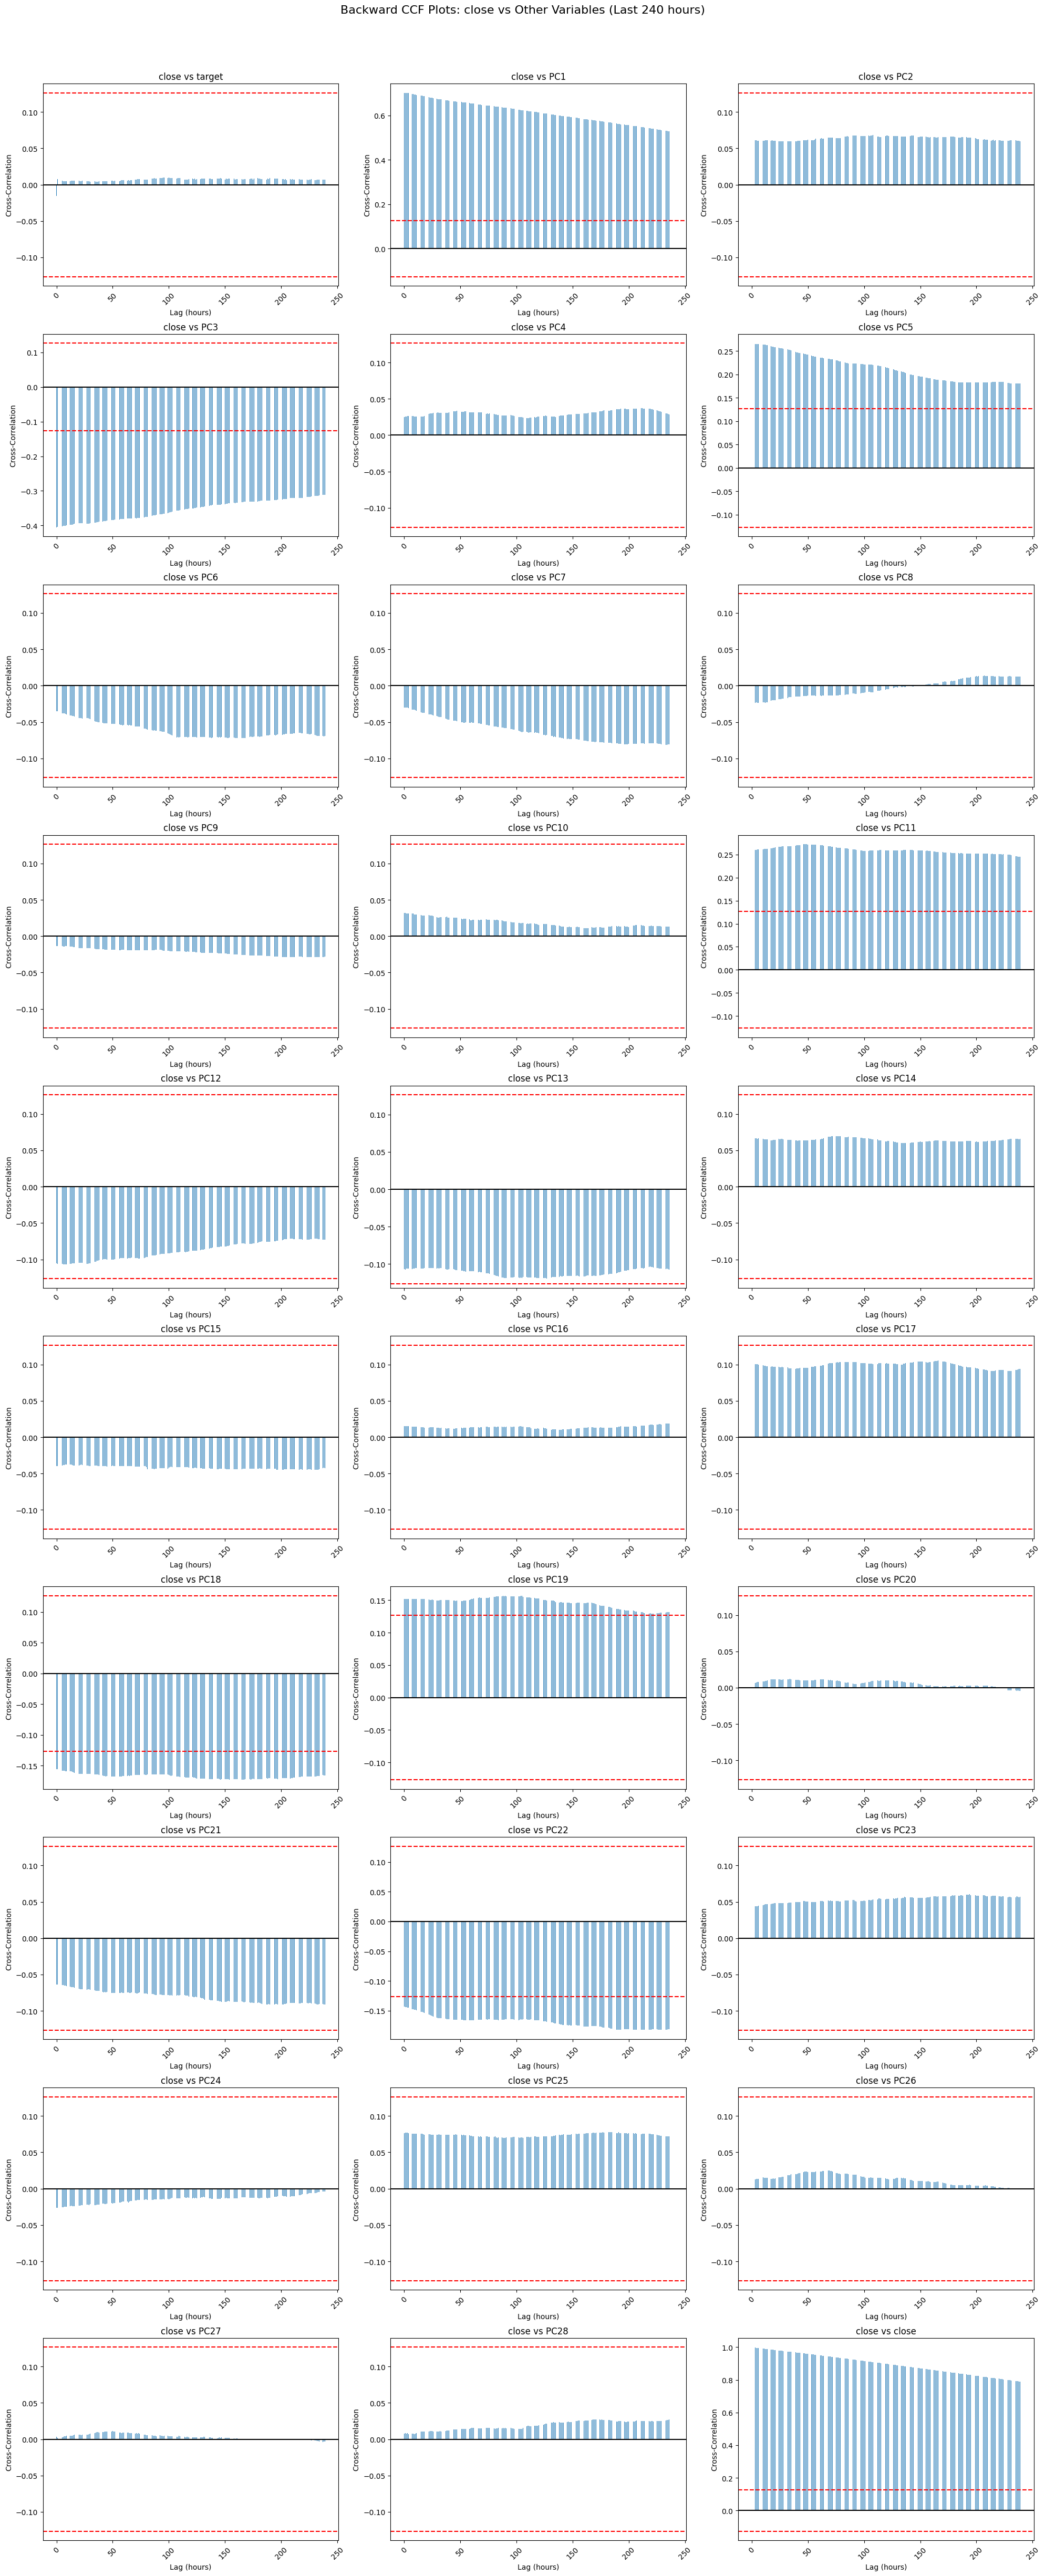

In [47]:
y_var = 'close'
x_vars = train2.drop('ID',axis=1).columns
ccf_grid = create_ccf_grid_plot(train2.drop('ID',axis=1), y_var, x_vars, max_lag=240)
plt.show()

# 6. 시계열 전처리

In [48]:
# moving average

def moving_average(df, columns, n_days, method = 'mean', adjust = True):
    """    
    df: 입력 DataFrame
    columns: 이동 평균을 계산할 컬럼 리스트
    n_days: 이동 평균을 계산할 기간 (일 수)
    adjust: 시작 지점에서의 편향을 조정할지 여부 (기본값: True)
    """

    output = df.copy()
    for col in columns:
        if method == 'mean':
            new_column_name = f"{col}_MA{n_days}"
            output[new_column_name] = output[col].rolling(window=n_days).mean()
        
        elif method == 'exponential':
            new_column_name = f"{col}_EMA{n_days}"
            output[new_column_name] = output[col].ewm(span=n_days, adjust=adjust).mean()
        
    return output

In [49]:
ma_col_lst = [f'PC{i+1}' for i in [1, 3, 5, 11, 18, 19, 22]]

df_select_ma = moving_average(final_df, ma_col_lst, 6)
df_select_ma = moving_average(df_select_ma, ma_col_lst, 12)
df_select_ma = moving_average(df_select_ma, ma_col_lst, 24)
df_select_ma = moving_average(df_select_ma, ma_col_lst, 48)
df_select_ma = moving_average(df_select_ma, ma_col_lst, 72)

In [50]:
def shift_feature(
    df: pd.DataFrame,
    conti_cols: List[str],
    intervals: List[int],
) -> List[pd.Series]:
    """
    연속형 변수의 shift feature 생성
    Args:
        df (pd.DataFrame)
        conti_cols (List[str]): continuous colnames
        intervals (List[int]): shifted intervals
    Return:
        List[pd.Series]
    """
    df_shift_dict = [
        df[conti_col].shift(interval).rename(f"{conti_col}_{interval}")
        for conti_col in conti_cols
        for interval in intervals
    ]
    return df_shift_dict

In [51]:
col_lst = [f'PC{i+1}' for i in [1, 3, 5, 11, 18, 19, 22]]

# 최대 24시간의 shift 피쳐를 계산
shift_list = shift_feature(
    df=df_select_ma, conti_cols=col_lst, intervals=[_ for _ in range(1, 24)]
)
df_select_ma_shift = pd.concat([df_select_ma, pd.concat(shift_list, axis=1)], axis=1)

In [52]:
df_select_ma_shift.head()

,ID,_type,target,PC1,PC2,PC3,PC4,PC5,PC6,PC7,...,PC23_14,PC23_15,PC23_16,PC23_17,PC23_18,PC23_19,PC23_20,PC23_21,PC23_22,PC23_23
0,2023-01-01 00:00:00,train,2.0,-3.246593,-1.060506,3.993831,-1.052320,-1.510954,3.920348,3.087378,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-01-01 01:00:00,train,1.0,-4.242344,1.531324,-0.391962,-1.751620,-0.877540,1.861153,1.762433,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-01-01 02:00:00,train,1.0,-5.419515,-0.181973,2.247102,-1.475482,-1.713839,4.975635,3.789977,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-01-01 03:00:00,train,1.0,-6.011601,-1.298299,0.905075,-0.379075,-0.573651,4.094699,2.198127,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-01-01 04:00:00,train,2.0,-4.712630,-1.055610,1.568022,-0.664683,-0.873327,3.610322,2.329974,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
df_select_ma_shift.shape

(11552, 227)

In [54]:
_target = df["target"]
df_select_ma_shift = df_select_ma_shift.ffill().fillna(-999).assign(target = _target)

train_df = df_select_ma_shift[df_select_ma_shift._type == 'train'].drop(columns = '_type')
test_df = df_select_ma_shift[df_select_ma_shift._type == 'test'].drop(columns = '_type')

In [60]:
df_select_ma_shift.to_csv('pca_df_select_ma_shift.csv')

# 7. 모델링

In [55]:
# train_test_split 으로 valid set, train set 분리
x_train_random, x_valid_random, y_train_random, y_valid_random = train_test_split(
    train_df.drop(columns = ['ID', 'target']), 
    train_df["target"].astype(int), 
    test_size=0.2,
    random_state=42,
    stratify=train_df["target"].astype(int) 
)

In [56]:
# time series valid, train set 분리
x_train_ts = train_df[train_df.ID < '2023-11-01'].drop(["target", "ID"], axis = 1)
y_train_ts = train_df[train_df.ID < '2023-11-01']["target"].astype(int)

x_valid_ts = train_df[train_df.ID >= '2023-11-01'].drop(["target", "ID"], axis = 1)
y_valid_ts = train_df[train_df.ID >= '2023-11-01']["target"].astype(int)

In [57]:
x_train_random.replace([np.inf, -np.inf], np.nan, inplace=True)
x_valid_random.replace([np.inf, -np.inf], np.nan, inplace=True)

x_train_ts.replace([np.inf, -np.inf], np.nan, inplace=True)
x_valid_ts.replace([np.inf, -np.inf], np.nan, inplace=True)

## (1) 모델 비교

In [74]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

def compare_model_accuracy(x_train, y_train, x_valid, y_valid):
    # 모델 정의
    xgb = XGBClassifier(n_estimators=100, random_state=42, learning_rate=0.01, max_depth=10, reg_lambda=1.0) 
    rf = RandomForestClassifier(n_estimators=100, random_state=42)  
    lgbm = LGBMClassifier(n_estimators=100, random_state=42, learning_rate=0.01, max_depth=10, reg_lambda=1.0) 
    cat = CatBoostClassifier(random_state=42, n_estimators=100, learning_rate=0.01, depth=10, l2_leaf_reg=3, verbose=0) 
    lr = LogisticRegression(random_state=42, C=1.0, max_iter=200)  # C 값이 작을수록 강한 규제
    
    # 모델 학습
    xgb.fit(x_train, y_train)
    rf.fit(x_train, y_train)
    lgbm.fit(x_train, y_train)
    cat.fit(x_train, y_train)
    lr.fit(x_train, y_train)
    
    # 모델 예측
    pred_xgb = xgb.predict(x_valid)
    pred_rf = rf.predict(x_valid)
    pred_lgbm = lgbm.predict(x_valid)
    pred_cat = cat.predict(x_valid)
    pred_lr = lr.predict(x_valid)
    
    # 정확도 계산
    acc_xgb = accuracy_score(y_valid, pred_xgb)
    acc_rf = accuracy_score(y_valid, pred_rf)
    acc_lgbm = accuracy_score(y_valid, pred_lgbm)
    acc_cat = accuracy_score(y_valid, pred_cat)
    acc_lr = accuracy_score(y_valid, pred_lr)
    
    # 결과 출력
    print(f"XGBoost Accuracy: {acc_xgb:.4f}")
    print(f"RandomForest Accuracy: {acc_rf:.4f}")
    print(f"LightGBM Accuracy: {acc_lgbm:.4f}")
    print(f"CatBoost Accuracy: {acc_cat:.4f}")
    print(f"LogisticRegression Accuracy: {acc_lr:.4f}")
    
    return xgb, rf, lgbm, cat, lr, acc_xgb, acc_rf, acc_lgbm, acc_cat, acc_lr, pred_xgb, pred_rf, pred_lgbm, pred_cat, pred_lr




In [75]:
xgb_random, rf_random, lgbm_random, cat_random, lr_random, acc_xgb_random, acc_rf_random, acc_lgbm_random, acc_cat_random, acc_lr_random, pred_xgb_random, pred_rf_random, pred_lgbm_random, pred_cat_random, pred_lr_random = compare_model_accuracy(x_train_random, y_train_random, x_valid_random, y_valid_random)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 224
[LightGBM] [Info] Start training from score -2.471301
[LightGBM] [Info] Start training from score -0.905010
[LightGBM] [Info] Start training from score -0.869664
[LightGBM] [Info] Start training from score -2.387109
XGBoost Accuracy: 0.4326
RandomForest Accuracy: 0.4378
LightGBM Accuracy: 0.4538
CatBoost Accuracy: 0.4344
LogisticRegression Accuracy: 0.4503


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [76]:
xgb_ts, rf_ts, lgbm_ts, cat_ts, lr_ts, acc_xgb_ts, acc_rf_ts, acc_lgbm_ts, acc_cat_ts, acc_lr_ts, pred_xgb_ts, pred_rf_ts, pred_lgbm_ts, pred_cat_ts, pred_lr_ts = compare_model_accuracy(x_train_ts, y_train_ts, x_valid_ts, y_valid_ts)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 7296, number of used features: 224
[LightGBM] [Info] Start training from score -2.463750
[LightGBM] [Info] Start training from score -0.901799
[LightGBM] [Info] Start training from score -0.875469
[LightGBM] [Info] Start training from score -2.381851
XGBoost Accuracy: 0.4016
RandomForest Accuracy: 0.4324
LightGBM Accuracy: 0.4460
CatBoost Accuracy: 0.4529
LogisticRegression Accuracy: 0.1346


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


- 모델은 catboost,xgboost, lgbm으로 선정

## (2) Voting

In [83]:
from sklearn.ensemble import VotingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

def modelfitting(x_train, y_train, x_valid, y_valid):
    # 모델 정의
    cat = CatBoostClassifier(random_state=42, 
                             n_estimators=100, 
                             learning_rate=0.01, 
                             depth=10,
                             l2_leaf_reg=3,
                             metric_period=10)

    xgb = XGBClassifier(n_estimators=100, 
                        random_state=42, 
                        learning_rate=0.01, 
                        max_depth=10,)

    lgbm = LGBMClassifier(n_estimators=100, 
                          objective = 'multiclass',
                          metric = "multi_logloss", 
                          random_state=42, 
                          learning_rate=0.01, 
                          max_depth=10,
                          num_leaves= 30,
                          num_class = 4,
                          boosting_type= 'gbdt',
                          verbose = -1)

    # Voting
    vote_model = VotingClassifier(
        estimators=[("cat", cat), ("xgb", xgb), ("lgbm", lgbm)],
        voting='soft'  # 또는 'hard', 필요에 따라 선택
    )

    # 모델 학습
    vote_model.fit(x_train, y_train)
    cat.fit(x_train, y_train, verbose=10)
    evals = [(x_valid, y_valid)]
    xgb.fit(x_train, y_train, eval_set=evals, verbose=10)
    lgbm.fit(x_train, y_train)  # LGBM 모델 학습

    # 예측
    pred_vote = vote_model.predict(x_valid)
    pred_cat = cat.predict(x_valid)
    pred_xgb = xgb.predict(x_valid)
    pred_lgbm = lgbm.predict(x_valid)

    # 정확도 계산
    acc_vote = accuracy_score(y_valid, pred_vote)
    acc_cat = accuracy_score(y_valid, pred_cat)
    acc_xgb = accuracy_score(y_valid, pred_xgb)
    acc_lgbm = accuracy_score(y_valid, pred_lgbm)

    return vote_model, cat, xgb, lgbm, pred_vote, pred_cat, pred_xgb, pred_lgbm, acc_vote, acc_cat, acc_xgb, acc_lgbm



In [84]:
vote_model_random, cat_model_random, xgb_model_random, lgbm_model_random, pred_vote_random, pred_cat_random, pred_xgb_random, pred_lgbm_random, acc_vote_random, acc_cat_random, acc_xgb_random, acc_lgbm_random = modelfitting(x_train_random, y_train_random, x_valid_random, y_valid_random)


0:	learn: 1.3824698	total: 494ms	remaining: 48.9s
10:	learn: 1.3476220	total: 5.45s	remaining: 44.1s
20:	learn: 1.3162082	total: 10.7s	remaining: 40.3s
30:	learn: 1.2879950	total: 15.7s	remaining: 34.9s
40:	learn: 1.2628919	total: 20.7s	remaining: 29.7s
50:	learn: 1.2391202	total: 25.6s	remaining: 24.6s
60:	learn: 1.2172067	total: 30.7s	remaining: 19.6s
70:	learn: 1.1971417	total: 35.6s	remaining: 14.6s
80:	learn: 1.1787170	total: 40.6s	remaining: 9.52s
90:	learn: 1.1614016	total: 45.5s	remaining: 4.5s
99:	learn: 1.1468305	total: 50s	remaining: 0us
0:	learn: 1.3824698	total: 494ms	remaining: 48.9s
10:	learn: 1.3476220	total: 5.56s	remaining: 45s
20:	learn: 1.3162082	total: 10.6s	remaining: 40s
30:	learn: 1.2879950	total: 15.7s	remaining: 34.9s
40:	learn: 1.2628919	total: 20.8s	remaining: 29.9s
50:	learn: 1.2391202	total: 25.8s	remaining: 24.8s
60:	learn: 1.2172067	total: 30.9s	remaining: 19.7s
70:	learn: 1.1971417	total: 36s	remaining: 14.7s
80:	learn: 1.1787170	total: 41.1s	remaining:

In [85]:
print(acc_vote_random, acc_cat_random, acc_xgb_random, acc_lgbm_random)


0.4406392694063927 0.4343607305936073 0.432648401826484 0.4503424657534247


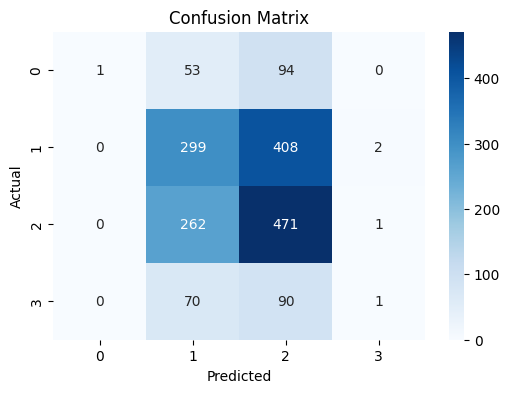

In [90]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_valid_random,pred_vote_random)

# 시각화
plt.figure(figsize=(6,4))
sns.heatmap(cm,annot=True,fmt="d",cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title('Confusion Matrix')
plt.show()

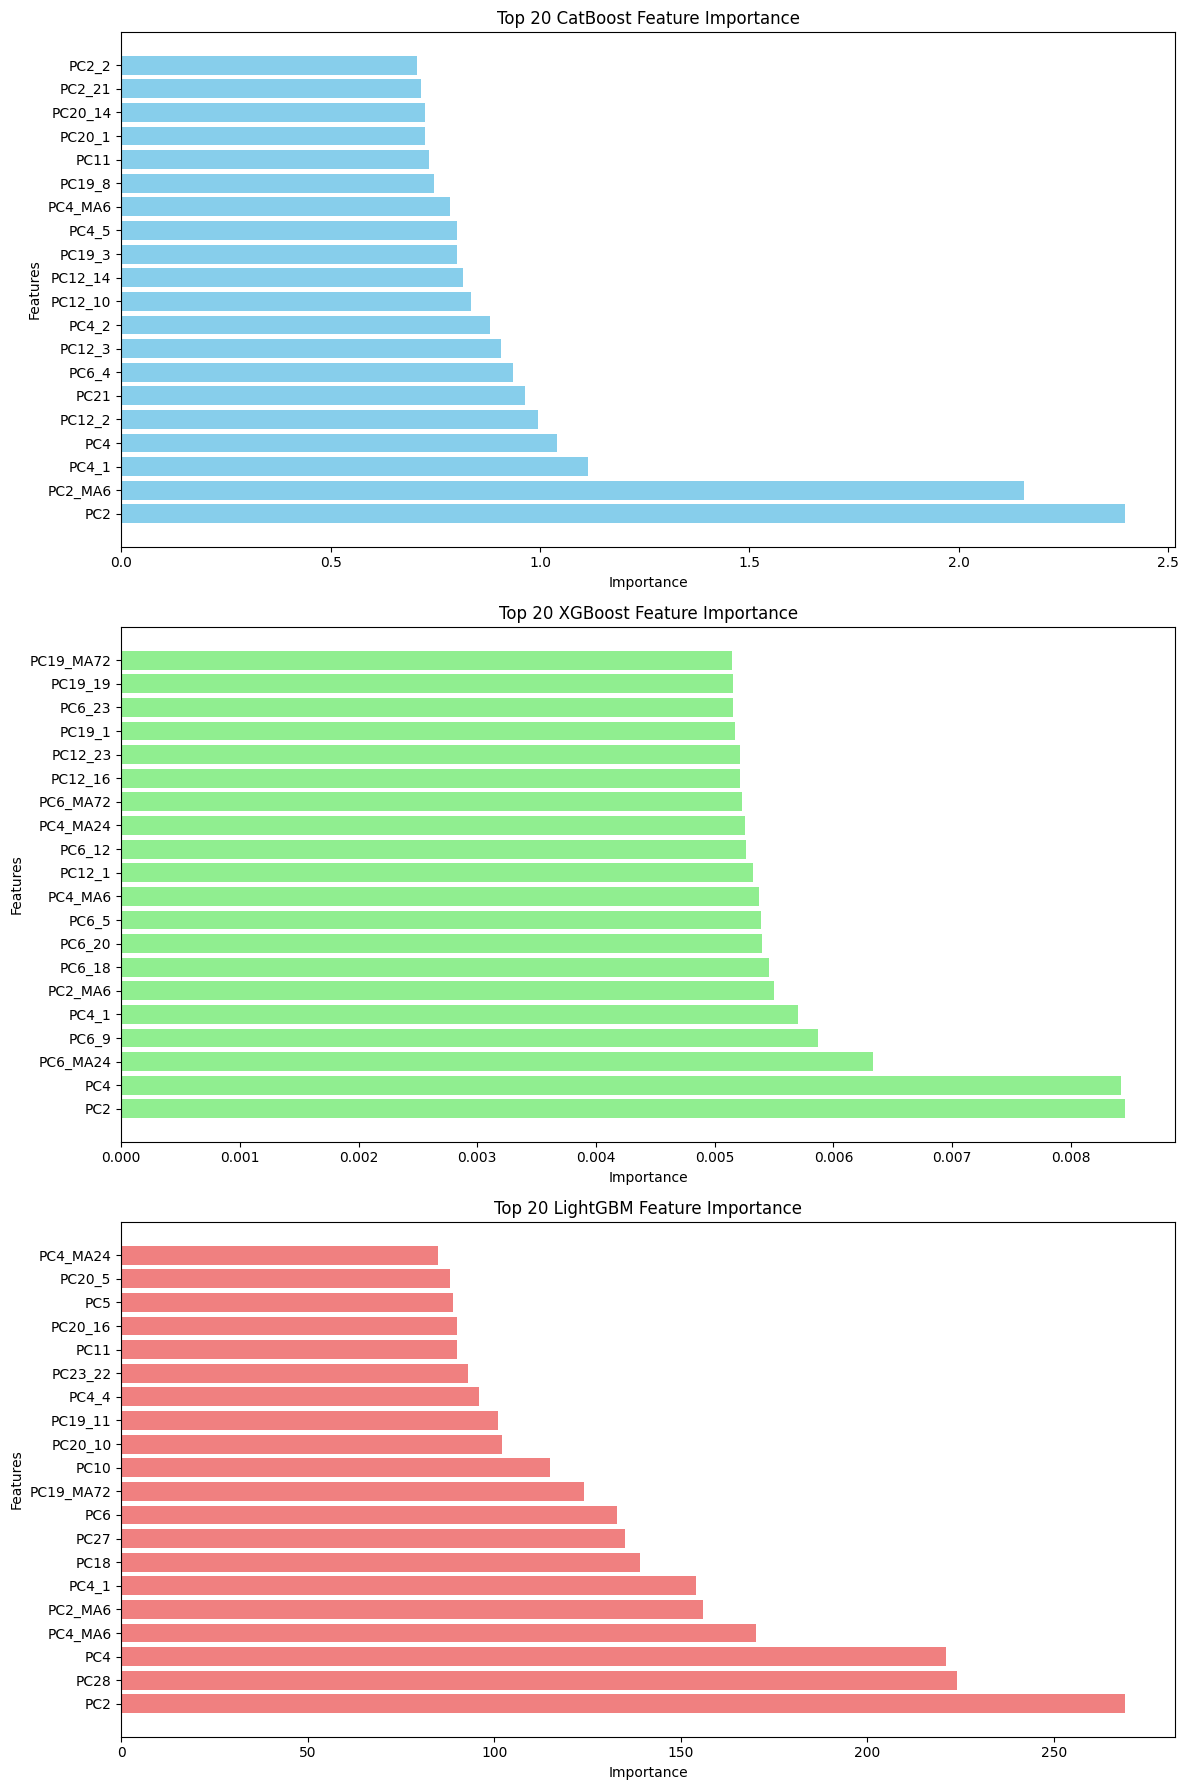

In [127]:
import pandas as pd
import matplotlib.pyplot as plt

# 변수 중요도 추출
cat_importance = cat_random.get_feature_importance()
xgb_importance = xgb_random.feature_importances_
lgbm_importance = lgbm_random.feature_importances_

# 변수 이름 가져오기
feature_names = x_train_random.columns

# DataFrame으로 변환하여 정렬
cat_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': cat_importance})
xgb_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': xgb_importance})
lgbm_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': lgbm_importance})

# 상위 20개 변수 중요도 추출
top_cat_importance = cat_importance_df.nlargest(20, 'Importance')
top_xgb_importance = xgb_importance_df.nlargest(20, 'Importance')
top_lgbm_importance = lgbm_importance_df.nlargest(20, 'Importance')

# 시각화
plt.figure(figsize=(12, 18))

# CatBoost 상위 20개 변수 중요도
plt.subplot(3, 1, 1)
plt.barh(top_cat_importance['Feature'], top_cat_importance['Importance'], color='skyblue')
plt.title('Top 20 CatBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')

# XGBoost 상위 20개 변수 중요도
plt.subplot(3, 1, 2)
plt.barh(top_xgb_importance['Feature'], top_xgb_importance['Importance'], color='lightgreen')
plt.title('Top 20 XGBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')

# LightGBM 상위 20개 변수 중요도
plt.subplot(3, 1, 3)
plt.barh(top_lgbm_importance['Feature'], top_lgbm_importance['Importance'], color='lightcoral')
plt.title('Top 20 LightGBM Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')

plt.tight_layout()
plt.show()


In [128]:
# 각 모델의 feature 집합 생성
cat_features = set(top_cat_importance['Feature'])
xgb_features = set(top_xgb_importance['Feature'])
lgbm_features = set(top_lgbm_importance['Feature'])

# 모든 feature 집합을 합쳐서 중복 없는 feature 추출
all_unique_features_11 = (cat_features | xgb_features | lgbm_features)

# 결과 출력
print(f"All Unique Features: {all_unique_features_11}")
print(len(all_unique_features_11))


All Unique Features: {'PC5', 'PC6_5', 'PC4_5', 'PC10', 'PC19_3', 'PC6_MA24', 'PC23_22', 'PC4_2', 'PC11', 'PC2_MA6', 'PC6_20', 'PC21', 'PC4', 'PC2_21', 'PC12_16', 'PC2', 'PC12_1', 'PC20_16', 'PC20_5', 'PC28', 'PC4_4', 'PC12_23', 'PC19_1', 'PC6_18', 'PC19_8', 'PC4_MA24', 'PC20_1', 'PC12_14', 'PC6_12', 'PC27', 'PC4_1', 'PC12_10', 'PC19_11', 'PC6_23', 'PC2_2', 'PC19_19', 'PC20_14', 'PC12_3', 'PC18', 'PC4_MA6', 'PC20_10', 'PC6_9', 'PC6_4', 'PC12_2', 'PC6', 'PC19_MA72', 'PC6_MA72'}
47


In [102]:
vote_model_ts, cat_model_ts, xgb_model_ts, lgbm_model_ts, pred_vote_ts, pred_cat_ts, pred_xgb_ts, pred_lgbm_ts, acc_vote_ts, acc_cat_ts, acc_xgb_ts, acc_lgbm_ts = modelfitting(x_train_ts, y_train_ts, x_valid_ts, y_valid_ts)


0:	learn: 1.3825394	total: 496ms	remaining: 49.1s
10:	learn: 1.3469885	total: 5.46s	remaining: 44.2s
20:	learn: 1.3157244	total: 10.4s	remaining: 39s
30:	learn: 1.2878965	total: 15.5s	remaining: 34.6s
40:	learn: 1.2624020	total: 20.6s	remaining: 29.7s
50:	learn: 1.2387830	total: 25.8s	remaining: 24.8s
60:	learn: 1.2170554	total: 30.7s	remaining: 19.6s
70:	learn: 1.1972602	total: 35.6s	remaining: 14.5s
80:	learn: 1.1789088	total: 40.8s	remaining: 9.57s
90:	learn: 1.1620902	total: 45.8s	remaining: 4.53s
99:	learn: 1.1477955	total: 50.2s	remaining: 0us
0:	learn: 1.3825394	total: 492ms	remaining: 48.8s
10:	learn: 1.3469885	total: 5.47s	remaining: 44.3s
20:	learn: 1.3157244	total: 10.5s	remaining: 39.4s
30:	learn: 1.2878965	total: 15.5s	remaining: 34.4s
40:	learn: 1.2624020	total: 20.4s	remaining: 29.4s
50:	learn: 1.2387830	total: 25.3s	remaining: 24.3s
60:	learn: 1.2170554	total: 30.3s	remaining: 19.4s
70:	learn: 1.1972602	total: 35.3s	remaining: 14.4s
80:	learn: 1.1789088	total: 40.5s	rem

In [106]:
print(acc_vote_ts, acc_cat_ts, acc_xgb_ts, acc_lgbm_ts)

0.4494535519125683 0.45286885245901637 0.4016393442622951 0.44672131147540983


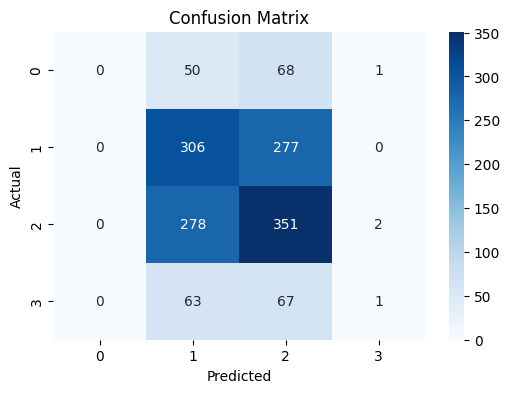

In [107]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_valid_ts,pred_vote_ts)

# 시각화
plt.figure(figsize=(6,4))
sns.heatmap(cm,annot=True,fmt="d",cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title('Confusion Matrix')
plt.show()

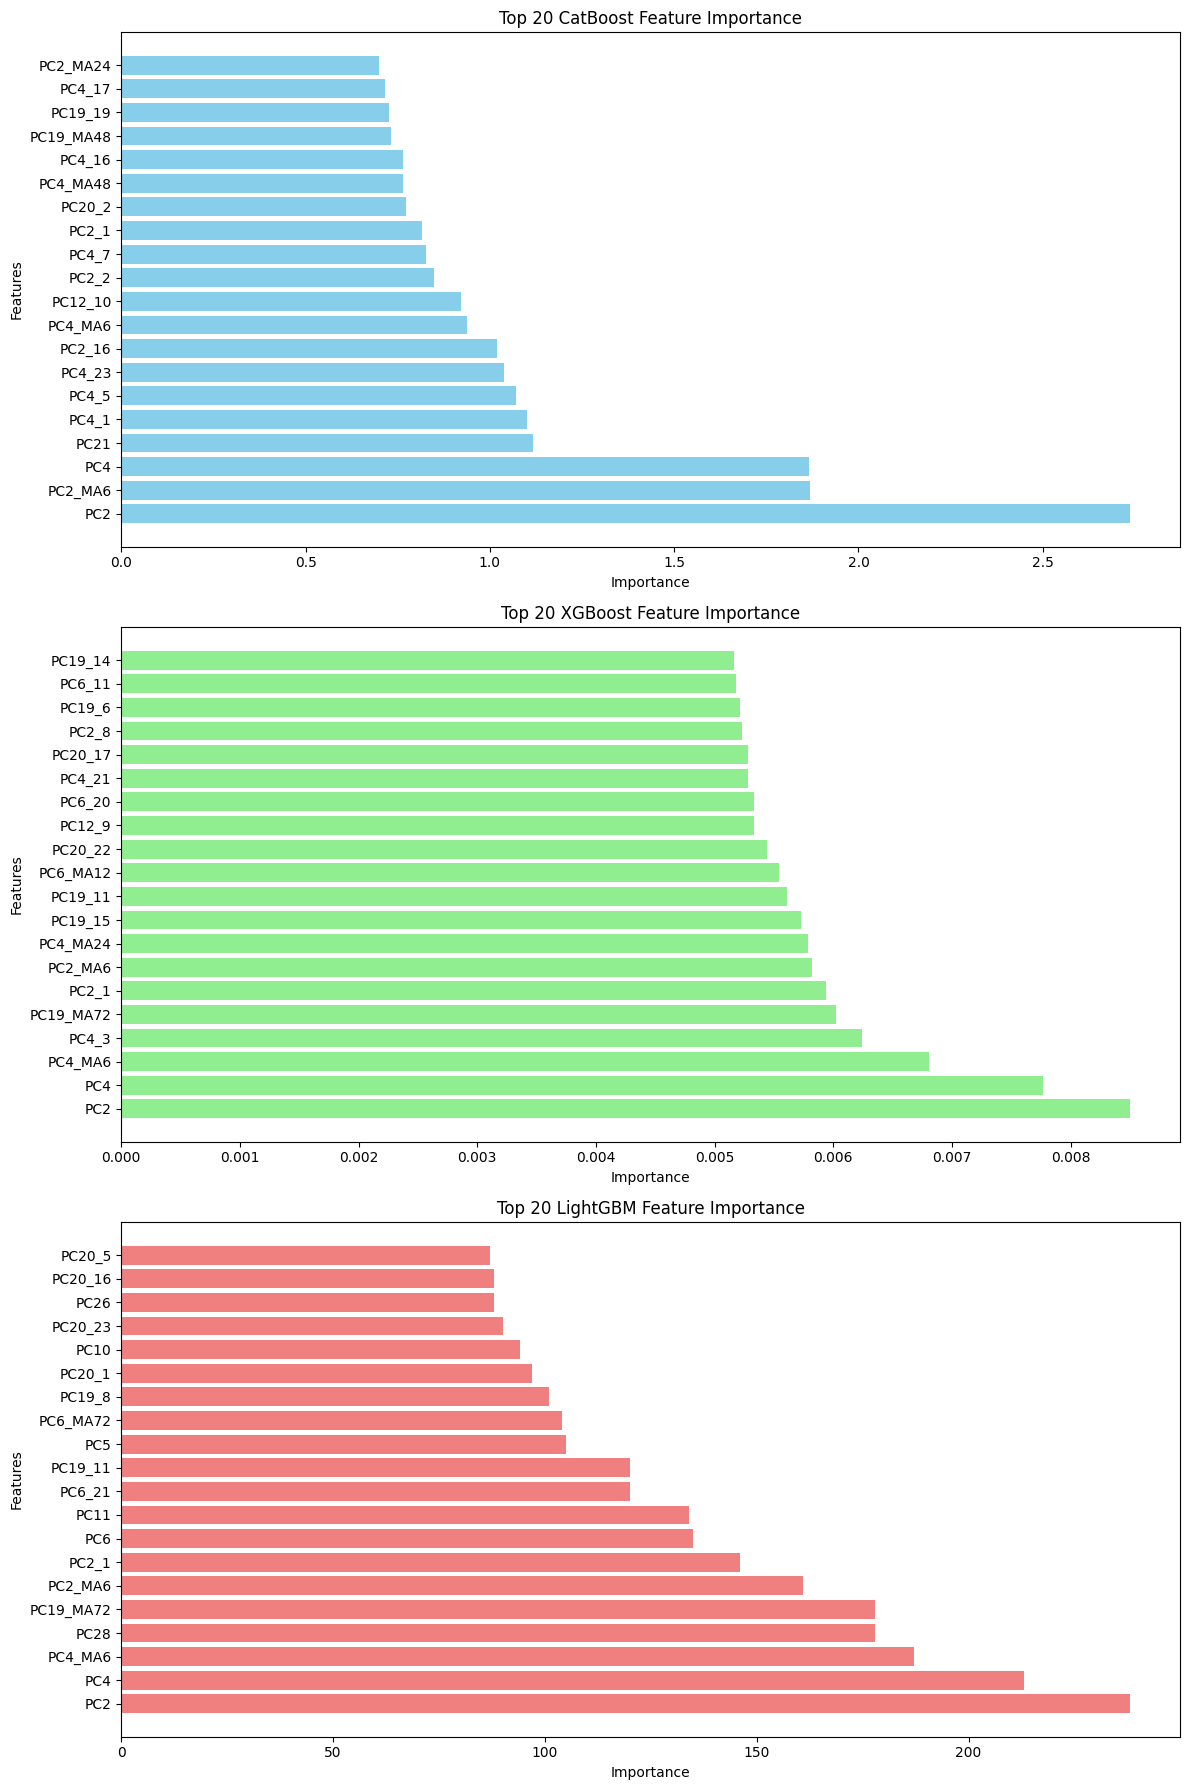

In [108]:
import pandas as pd
import matplotlib.pyplot as plt

# 변수 중요도 추출
cat_importance = cat_ts.get_feature_importance()
xgb_importance = xgb_ts.feature_importances_
lgbm_importance = lgbm_ts.feature_importances_

# 변수 이름 가져오기
feature_names = x_train_random.columns

# DataFrame으로 변환하여 정렬
cat_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': cat_importance})
xgb_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': xgb_importance})
lgbm_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': lgbm_importance})

# 상위 20개 변수 중요도 추출
top_cat_importance = cat_importance_df.nlargest(20, 'Importance')
top_xgb_importance = xgb_importance_df.nlargest(20, 'Importance')
top_lgbm_importance = lgbm_importance_df.nlargest(20, 'Importance')

# 시각화
plt.figure(figsize=(12, 18))

# CatBoost 상위 20개 변수 중요도
plt.subplot(3, 1, 1)
plt.barh(top_cat_importance['Feature'], top_cat_importance['Importance'], color='skyblue')
plt.title('Top 20 CatBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')

# XGBoost 상위 20개 변수 중요도
plt.subplot(3, 1, 2)
plt.barh(top_xgb_importance['Feature'], top_xgb_importance['Importance'], color='lightgreen')
plt.title('Top 20 XGBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')

# LightGBM 상위 20개 변수 중요도
plt.subplot(3, 1, 3)
plt.barh(top_lgbm_importance['Feature'], top_lgbm_importance['Importance'], color='lightcoral')
plt.title('Top 20 LightGBM Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')

plt.tight_layout()
plt.show()


In [109]:
# 각 모델의 feature 집합 생성
cat_features = set(top_cat_importance['Feature'])
xgb_features = set(top_xgb_importance['Feature'])
lgbm_features = set(top_lgbm_importance['Feature'])

# 모든 feature 집합을 합쳐서 중복 없는 feature 추출
all_unique_features_12 = (cat_features | xgb_features | lgbm_features)

# 결과 출력
print(f"All Unique Features: {all_unique_features_12}")
print(len(all_unique_features_12))


All Unique Features: {'PC5', 'PC4_5', 'PC10', 'PC2_1', 'PC26', 'PC11', 'PC6_MA12', 'PC2_MA6', 'PC6_20', 'PC4', 'PC21', 'PC19_15', 'PC19_14', 'PC2', 'PC20_16', 'PC20_5', 'PC28', 'PC4_17', 'PC19_6', 'PC19_8', 'PC6_21', 'PC19_MA48', 'PC4_MA48', 'PC4_MA24', 'PC20_22', 'PC20_1', 'PC2_MA24', 'PC4_1', 'PC12_10', 'PC19_11', 'PC4_7', 'PC20_17', 'PC12_9', 'PC2_2', 'PC19_19', 'PC2_8', 'PC4_23', 'PC4_MA6', 'PC20_2', 'PC2_16', 'PC4_16', 'PC4_3', 'PC4_21', 'PC20_23', 'PC6_11', 'PC6', 'PC19_MA72', 'PC6_MA72'}
48


In [115]:
all_unique_features = all_unique_features_11 | all_unique_features_12
print(len(all_unique_features))
print(all_unique_features)

71
{'PC5', 'PC6_MA24', 'PC23_22', 'PC2_1', 'PC26', 'PC11', 'PC6_MA12', 'PC2_MA6', 'PC6_20', 'PC21', 'PC4', 'PC2_21', 'PC12_16', 'PC12_1', 'PC20_16', 'PC20_5', 'PC4_4', 'PC12_23', 'PC6_21', 'PC19_MA48', 'PC4_MA48', 'PC20_1', 'PC12_14', 'PC6_12', 'PC27', 'PC4_1', 'PC12_9', 'PC6_23', 'PC19_19', 'PC20_14', 'PC4_23', 'PC18', 'PC20_2', 'PC2_16', 'PC4_16', 'PC6_4', 'PC6', 'PC19_1', 'PC19_MA72', 'PC6_5', 'PC4_5', 'PC10', 'PC19_3', 'PC4_2', 'PC19_15', 'PC19_14', 'PC2', 'PC28', 'PC4_17', 'PC19_6', 'PC6_18', 'PC19_8', 'PC4_MA24', 'PC20_22', 'PC2_MA24', 'PC12_10', 'PC19_11', 'PC4_7', 'PC20_17', 'PC2_2', 'PC2_8', 'PC12_3', 'PC4_MA6', 'PC20_10', 'PC6_9', 'PC4_3', 'PC4_21', 'PC20_23', 'PC12_2', 'PC6_11', 'PC6_MA72'}


## (3) Stacking

In [116]:
from sklearn.ensemble import StackingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

def modelfitting2(x_train, y_train, x_valid, y_valid):
    # 모델 정의
    cat = CatBoostClassifier(random_state=42, 
                             n_estimators=100, 
                             learning_rate=0.01, 
                             depth=10,
                             l2_leaf_reg=3,
                             metric_period=10)

    xgb = XGBClassifier(n_estimators=100, 
                        random_state=42, 
                        learning_rate=0.01, 
                        max_depth=10,)

    lgbm = LGBMClassifier(n_estimators=100, 
                          objective = 'multiclass',
                          metric = "multi_logloss", 
                          random_state=42, 
                          learning_rate=0.01, 
                          max_depth=10,
                          num_leaves= 30,
                          num_class = 4,
                          boosting_type= 'gbdt',
                          verbose = -1)

    # Stacking
    stacking_model = StackingClassifier(
    estimators=[('lgbm', lgbm), ('cat', cat), ('xgb', xgb)],
    final_estimator=LogisticRegression()  # 메타 모델
    )

    # 모델 학습
    stacking_model.fit(x_train, y_train)
    cat.fit(x_train, y_train, verbose=10)
    evals = [(x_valid, y_valid)]
    xgb.fit(x_train, y_train, eval_set=evals, verbose=10)
    lgbm.fit(x_train, y_train)  # LGBM 모델 학습

    # 예측
    pred_stack = stacking_model.predict(x_valid)
    pred_cat = cat.predict(x_valid)
    pred_xgb = xgb.predict(x_valid)
    pred_lgbm = lgbm.predict(x_valid)

    # 정확도 계산
    acc_vote = accuracy_score(y_valid, pred_stack)
    acc_cat = accuracy_score(y_valid, pred_cat)
    acc_xgb = accuracy_score(y_valid, pred_xgb)
    acc_lgbm = accuracy_score(y_valid, pred_lgbm)

    return stacking_model, cat, xgb, lgbm, pred_stack, pred_cat, pred_xgb, pred_lgbm, acc_vote, acc_cat, acc_xgb, acc_lgbm



In [117]:
stacking_model_random, cat_model_random, xgb_model_random, lgbm_model_random, pred_stacking_random, pred_cat_random, pred_xgb_random, pred_lgbm_random, acc_stacking_random, acc_cat_random, acc_xgb_random, acc_lgbm_random = modelfitting2(x_train_random, y_train_random, x_valid_random, y_valid_random)


0:	learn: 1.3824698	total: 485ms	remaining: 48s
10:	learn: 1.3476220	total: 5.38s	remaining: 43.5s
20:	learn: 1.3162082	total: 10.4s	remaining: 39.2s
30:	learn: 1.2879950	total: 15.3s	remaining: 34.1s
40:	learn: 1.2628919	total: 20.2s	remaining: 29.1s
50:	learn: 1.2391202	total: 25.3s	remaining: 24.3s
60:	learn: 1.2172067	total: 30.2s	remaining: 19.3s
70:	learn: 1.1971417	total: 35.1s	remaining: 14.3s
80:	learn: 1.1787170	total: 40s	remaining: 9.38s
90:	learn: 1.1614016	total: 44.9s	remaining: 4.44s
99:	learn: 1.1468305	total: 49.4s	remaining: 0us
0:	learn: 1.3827281	total: 499ms	remaining: 49.4s
10:	learn: 1.3476810	total: 5.43s	remaining: 44s
20:	learn: 1.3167902	total: 10.4s	remaining: 39.2s
30:	learn: 1.2885745	total: 15.5s	remaining: 34.6s
40:	learn: 1.2632881	total: 20.6s	remaining: 29.6s
50:	learn: 1.2388652	total: 25.8s	remaining: 24.7s
60:	learn: 1.2164816	total: 30.6s	remaining: 19.6s
70:	learn: 1.1962160	total: 35.6s	remaining: 14.5s
80:	learn: 1.1773480	total: 40.5s	remaini

In [118]:
print(acc_stacking_random, acc_cat_random, acc_xgb_random, acc_lgbm_random)


0.4440639269406393 0.4343607305936073 0.432648401826484 0.4503424657534247


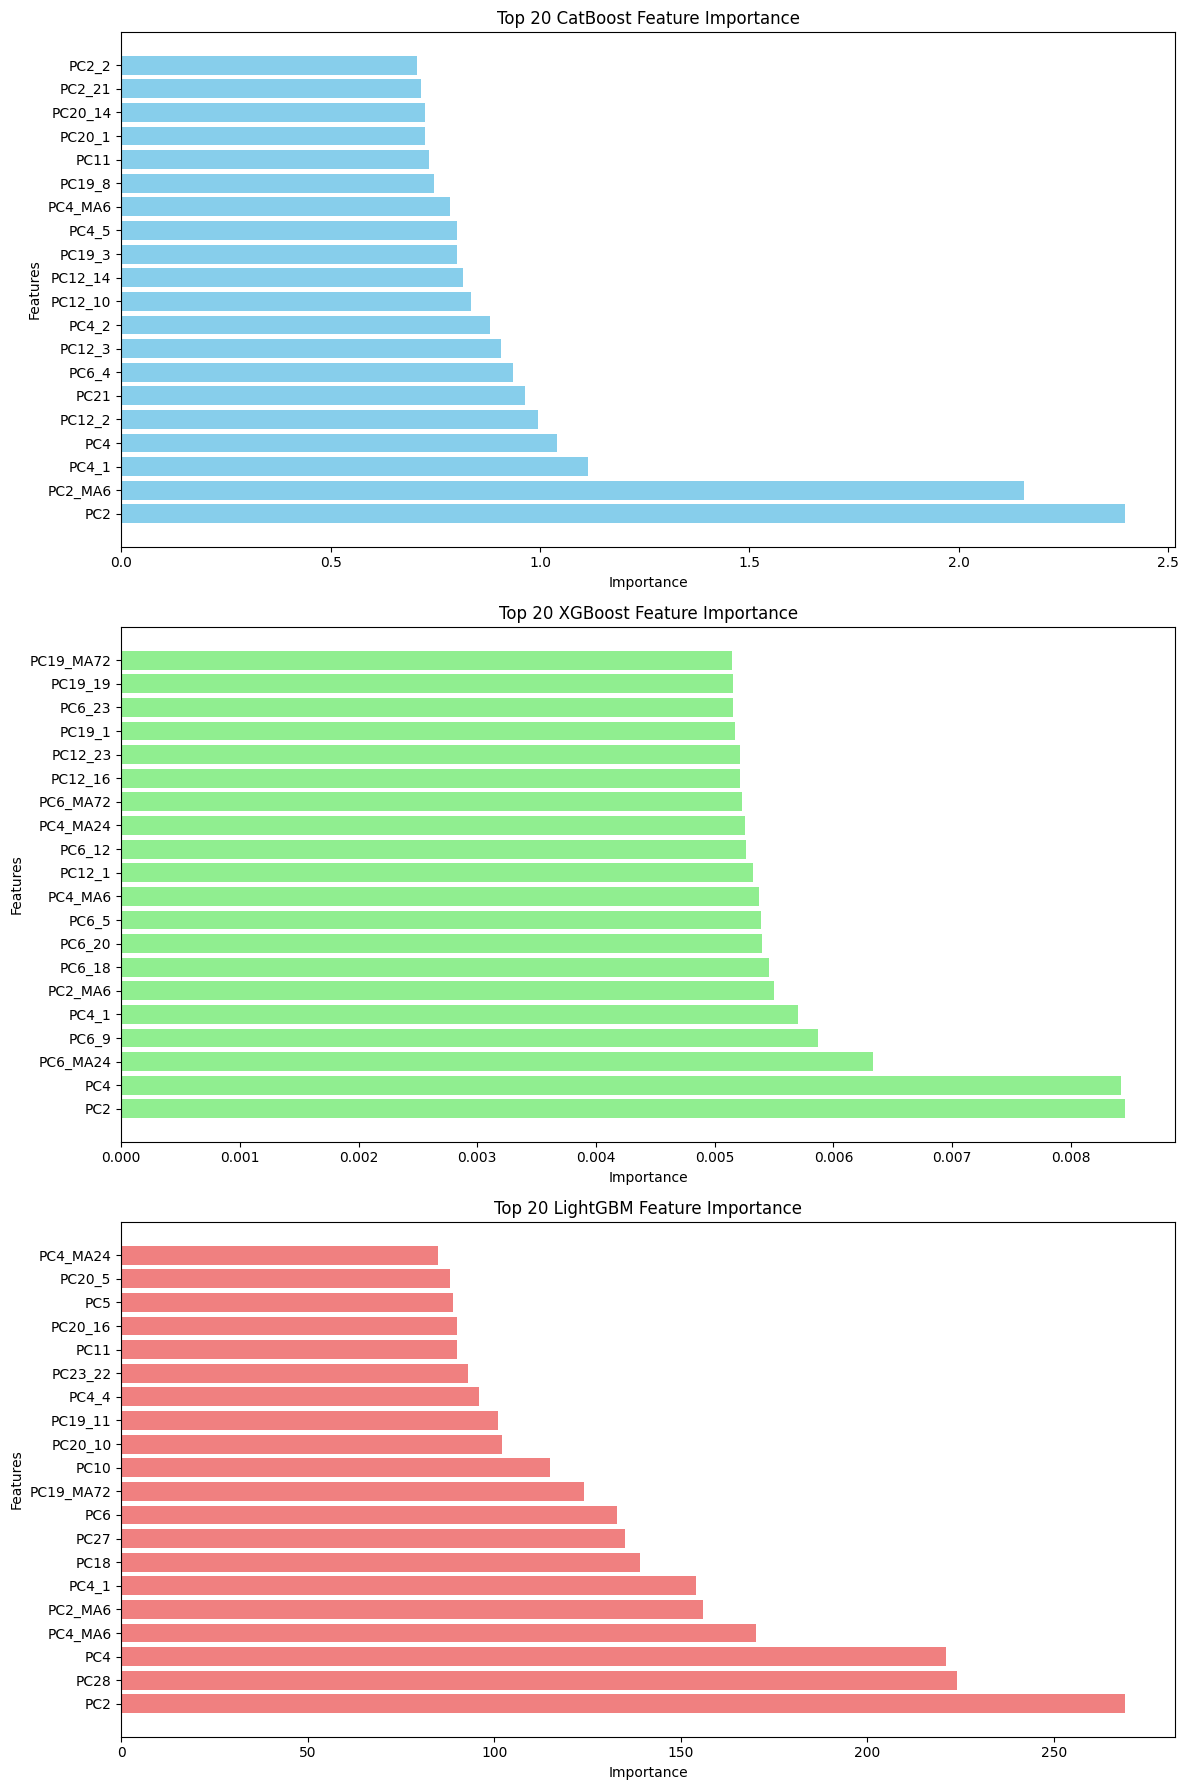

In [121]:
import pandas as pd
import matplotlib.pyplot as plt

# 변수 중요도 추출
cat_importance = cat_random.get_feature_importance()
xgb_importance = xgb_random.feature_importances_
lgbm_importance = lgbm_random.feature_importances_

# 변수 이름 가져오기
feature_names = x_train_random.columns

# DataFrame으로 변환하여 정렬
cat_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': cat_importance})
xgb_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': xgb_importance})
lgbm_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': lgbm_importance})

# 상위 20개 변수 중요도 추출
top_cat_importance = cat_importance_df.nlargest(20, 'Importance')
top_xgb_importance = xgb_importance_df.nlargest(20, 'Importance')
top_lgbm_importance = lgbm_importance_df.nlargest(20, 'Importance')

# 시각화
plt.figure(figsize=(12, 18))

# CatBoost 상위 20개 변수 중요도
plt.subplot(3, 1, 1)
plt.barh(top_cat_importance['Feature'], top_cat_importance['Importance'], color='skyblue')
plt.title('Top 20 CatBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')

# XGBoost 상위 20개 변수 중요도
plt.subplot(3, 1, 2)
plt.barh(top_xgb_importance['Feature'], top_xgb_importance['Importance'], color='lightgreen')
plt.title('Top 20 XGBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')

# LightGBM 상위 20개 변수 중요도
plt.subplot(3, 1, 3)
plt.barh(top_lgbm_importance['Feature'], top_lgbm_importance['Importance'], color='lightcoral')
plt.title('Top 20 LightGBM Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')

plt.tight_layout()
plt.show()


In [122]:
# 각 모델의 feature 집합 생성
cat_features = set(top_cat_importance['Feature'])
xgb_features = set(top_xgb_importance['Feature'])
lgbm_features = set(top_lgbm_importance['Feature'])

# 모든 feature 집합을 합쳐서 중복 없는 feature 추출
all_unique_features_21 = (cat_features | xgb_features | lgbm_features)

# 결과 출력
print(f"All Unique Features: {all_unique_features_21}")
print(len(all_unique_features_21))


All Unique Features: {'PC5', 'PC6_5', 'PC4_5', 'PC10', 'PC19_3', 'PC6_MA24', 'PC23_22', 'PC4_2', 'PC11', 'PC2_MA6', 'PC6_20', 'PC21', 'PC4', 'PC2_21', 'PC12_16', 'PC2', 'PC12_1', 'PC20_16', 'PC20_5', 'PC28', 'PC4_4', 'PC12_23', 'PC19_1', 'PC6_18', 'PC19_8', 'PC4_MA24', 'PC20_1', 'PC12_14', 'PC6_12', 'PC27', 'PC4_1', 'PC12_10', 'PC19_11', 'PC6_23', 'PC2_2', 'PC19_19', 'PC20_14', 'PC12_3', 'PC18', 'PC4_MA6', 'PC20_10', 'PC6_9', 'PC6_4', 'PC12_2', 'PC6', 'PC19_MA72', 'PC6_MA72'}
47


In [119]:
stacking_model_ts, cat_model_ts, xgb_model_ts, lgbm_model_ts, pred_stacking_ts, pred_cat_ts, pred_xgb_ts, pred_lgbm_ts, acc_stacking_ts, acc_cat_ts, acc_xgb_ts, acc_lgbm_ts = modelfitting2(x_train_ts, y_train_ts, x_valid_ts, y_valid_ts)


0:	learn: 1.3825394	total: 495ms	remaining: 49s
10:	learn: 1.3469885	total: 5.44s	remaining: 44s
20:	learn: 1.3157244	total: 10.4s	remaining: 39s
30:	learn: 1.2878965	total: 15.3s	remaining: 34.1s
40:	learn: 1.2624020	total: 20.3s	remaining: 29.3s
50:	learn: 1.2387830	total: 25.3s	remaining: 24.3s
60:	learn: 1.2170554	total: 30.3s	remaining: 19.4s
70:	learn: 1.1972602	total: 35.3s	remaining: 14.4s
80:	learn: 1.1789088	total: 40.3s	remaining: 9.45s
90:	learn: 1.1620902	total: 45.3s	remaining: 4.48s
99:	learn: 1.1477955	total: 49.8s	remaining: 0us
0:	learn: 1.3826085	total: 501ms	remaining: 49.6s
10:	learn: 1.3483396	total: 5.48s	remaining: 44.3s
20:	learn: 1.3172377	total: 10.4s	remaining: 39.1s
30:	learn: 1.2891614	total: 15.3s	remaining: 34.1s
40:	learn: 1.2636438	total: 20.3s	remaining: 29.2s
50:	learn: 1.2391047	total: 25.3s	remaining: 24.3s
60:	learn: 1.2169791	total: 30.2s	remaining: 19.3s
70:	learn: 1.1966405	total: 35.1s	remaining: 14.3s
80:	learn: 1.1775992	total: 40.1s	remaini

In [120]:
print(acc_vote_ts, acc_cat_ts, acc_xgb_ts, acc_lgbm_ts)


0.4494535519125683 0.45286885245901637 0.4016393442622951 0.44672131147540983


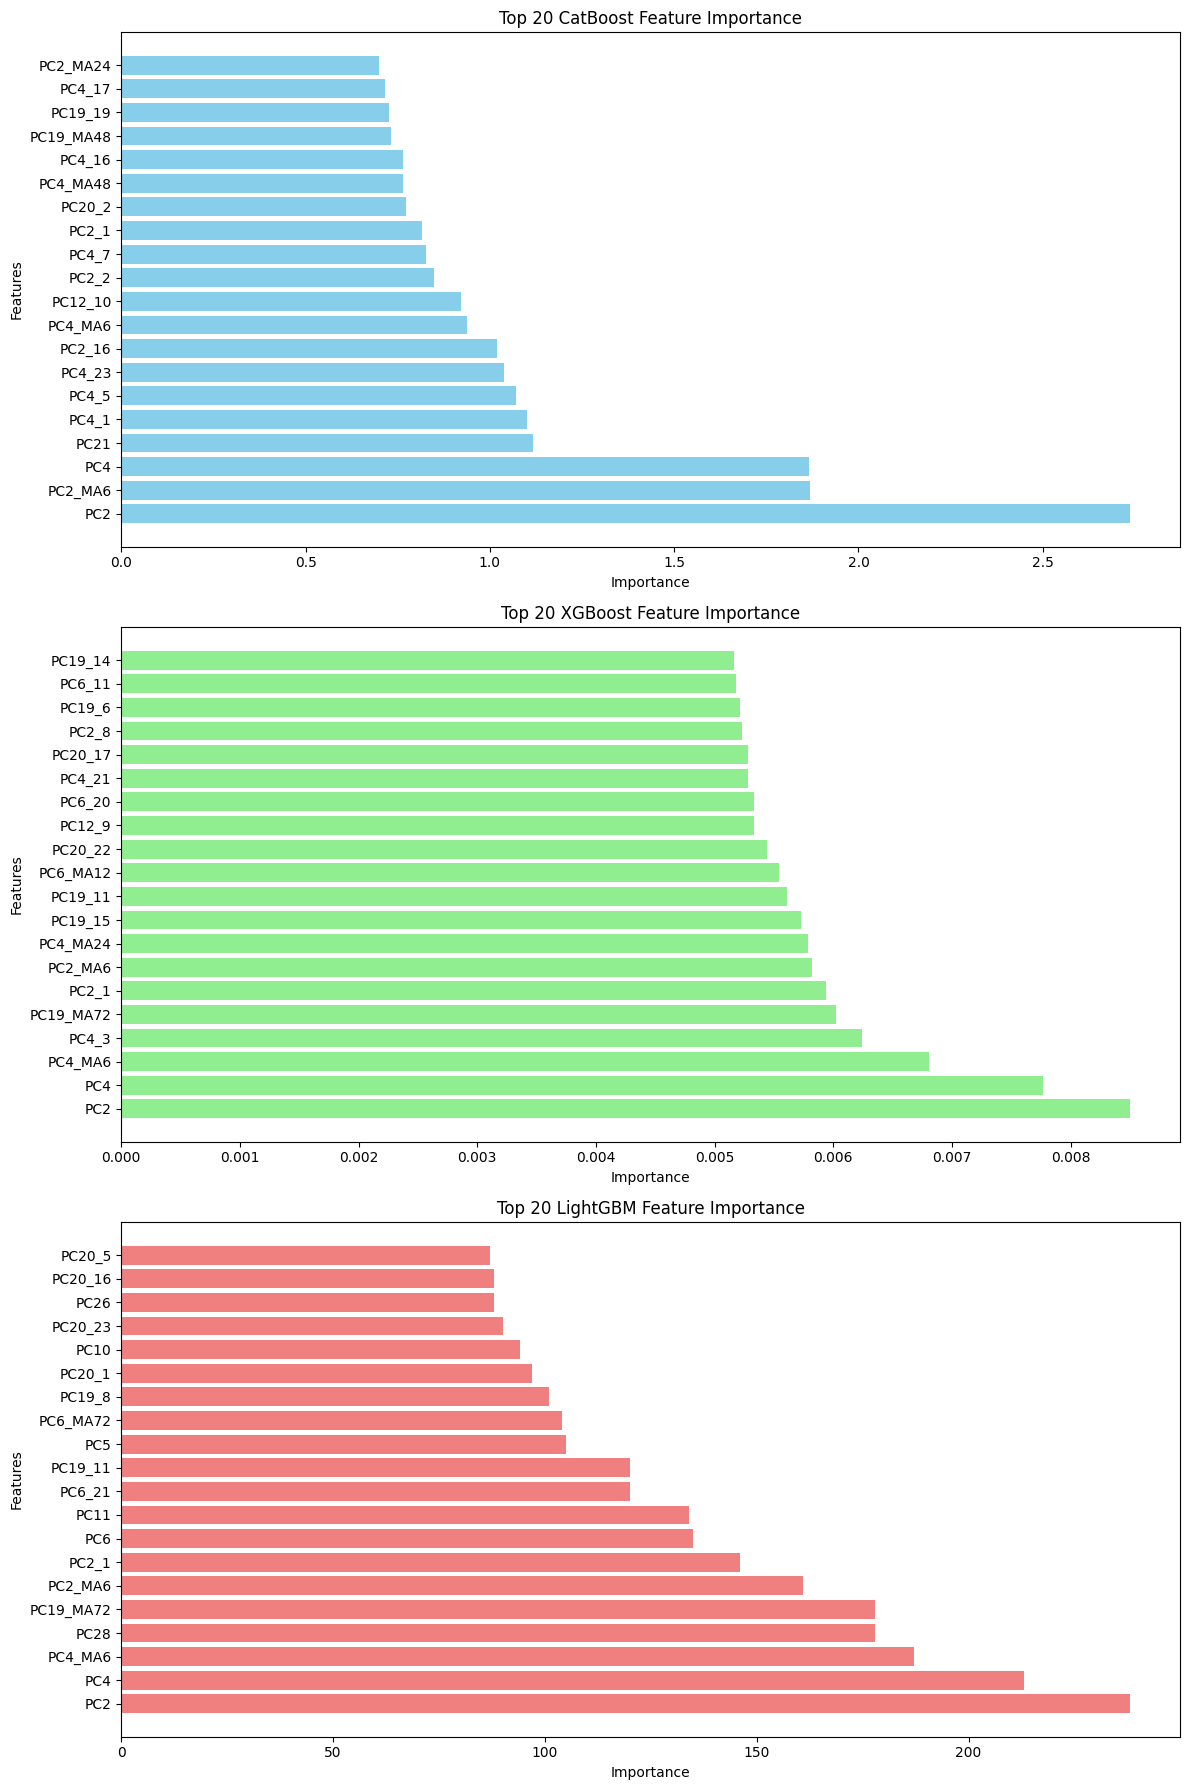

In [123]:
import pandas as pd
import matplotlib.pyplot as plt

# 변수 중요도 추출
cat_importance = cat_ts.get_feature_importance()
xgb_importance = xgb_ts.feature_importances_
lgbm_importance = lgbm_ts.feature_importances_

# 변수 이름 가져오기
feature_names = x_train_random.columns

# DataFrame으로 변환하여 정렬
cat_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': cat_importance})
xgb_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': xgb_importance})
lgbm_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': lgbm_importance})

# 상위 20개 변수 중요도 추출
top_cat_importance = cat_importance_df.nlargest(20, 'Importance')
top_xgb_importance = xgb_importance_df.nlargest(20, 'Importance')
top_lgbm_importance = lgbm_importance_df.nlargest(20, 'Importance')

# 시각화
plt.figure(figsize=(12, 18))

# CatBoost 상위 20개 변수 중요도
plt.subplot(3, 1, 1)
plt.barh(top_cat_importance['Feature'], top_cat_importance['Importance'], color='skyblue')
plt.title('Top 20 CatBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')

# XGBoost 상위 20개 변수 중요도
plt.subplot(3, 1, 2)
plt.barh(top_xgb_importance['Feature'], top_xgb_importance['Importance'], color='lightgreen')
plt.title('Top 20 XGBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')

# LightGBM 상위 20개 변수 중요도
plt.subplot(3, 1, 3)
plt.barh(top_lgbm_importance['Feature'], top_lgbm_importance['Importance'], color='lightcoral')
plt.title('Top 20 LightGBM Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')

plt.tight_layout()
plt.show()


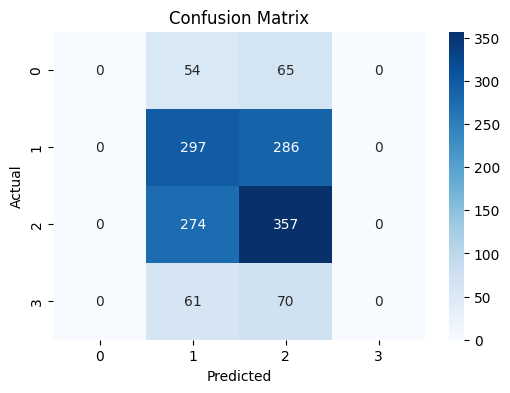

In [132]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_valid_ts,pred_stacking_ts)

# 시각화
plt.figure(figsize=(6,4))
sns.heatmap(cm,annot=True,fmt="d",cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title('Confusion Matrix')
plt.show()

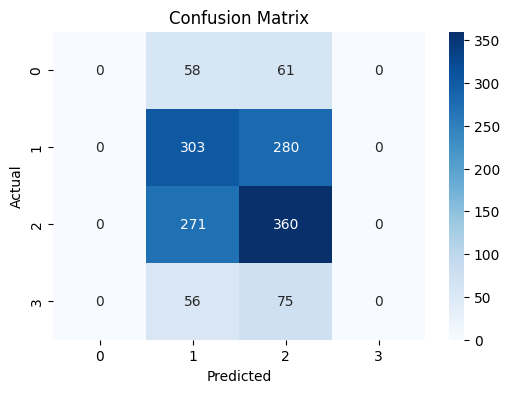

In [133]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_valid_ts,pred_cat_ts)

# 시각화
plt.figure(figsize=(6,4))
sns.heatmap(cm,annot=True,fmt="d",cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title('Confusion Matrix')
plt.show()

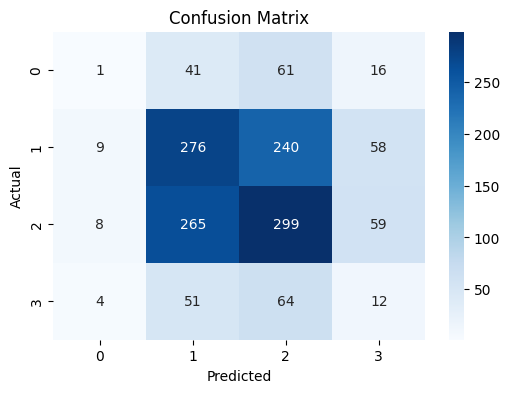

In [134]:

from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_valid_ts,pred_xgb_ts)

# 시각화
plt.figure(figsize=(6,4))
sns.heatmap(cm,annot=True,fmt="d",cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title('Confusion Matrix')
plt.show()

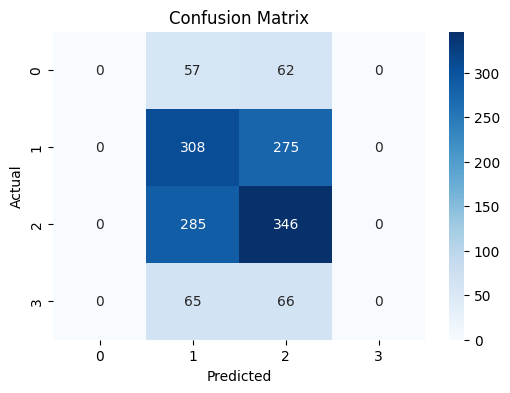

In [135]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_valid_ts,pred_lgbm_ts)

# 시각화
plt.figure(figsize=(6,4))
sns.heatmap(cm,annot=True,fmt="d",cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_valid_ts,pred_vote_ts)

# 시각화
plt.figure(figsize=(6,4))
sns.heatmap(cm,annot=True,fmt="d",cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title('Confusion Matrix')
plt.show()

In [124]:
# 각 모델의 feature 집합 생성
cat_features = set(top_cat_importance['Feature'])
xgb_features = set(top_xgb_importance['Feature'])
lgbm_features = set(top_lgbm_importance['Feature'])

# 모든 feature 집합을 합쳐서 중복 없는 feature 추출
all_unique_features_22 = (cat_features | xgb_features | lgbm_features)

# 결과 출력
print(f"All Unique Features: {all_unique_features_22}")
print(len(all_unique_features_22))


All Unique Features: {'PC5', 'PC4_5', 'PC10', 'PC2_1', 'PC26', 'PC11', 'PC6_MA12', 'PC2_MA6', 'PC6_20', 'PC4', 'PC21', 'PC19_15', 'PC19_14', 'PC2', 'PC20_16', 'PC20_5', 'PC28', 'PC4_17', 'PC19_6', 'PC19_8', 'PC6_21', 'PC19_MA48', 'PC4_MA48', 'PC4_MA24', 'PC20_22', 'PC20_1', 'PC2_MA24', 'PC4_1', 'PC12_10', 'PC19_11', 'PC4_7', 'PC20_17', 'PC12_9', 'PC2_2', 'PC19_19', 'PC2_8', 'PC4_23', 'PC4_MA6', 'PC20_2', 'PC2_16', 'PC4_16', 'PC4_3', 'PC4_21', 'PC20_23', 'PC6_11', 'PC6', 'PC19_MA72', 'PC6_MA72'}
48


In [126]:
all_unique_features2 = all_unique_features_21 | all_unique_features_22
print(len(all_unique_features2))
print(all_unique_features2)

71
{'PC5', 'PC6_MA24', 'PC23_22', 'PC2_1', 'PC26', 'PC11', 'PC6_MA12', 'PC2_MA6', 'PC6_20', 'PC21', 'PC4', 'PC2_21', 'PC12_16', 'PC12_1', 'PC20_16', 'PC20_5', 'PC4_4', 'PC12_23', 'PC6_21', 'PC19_MA48', 'PC4_MA48', 'PC20_1', 'PC12_14', 'PC6_12', 'PC27', 'PC4_1', 'PC12_9', 'PC6_23', 'PC19_19', 'PC20_14', 'PC4_23', 'PC18', 'PC20_2', 'PC2_16', 'PC4_16', 'PC6_4', 'PC6', 'PC19_1', 'PC19_MA72', 'PC6_5', 'PC4_5', 'PC10', 'PC19_3', 'PC4_2', 'PC19_15', 'PC19_14', 'PC2', 'PC28', 'PC4_17', 'PC19_6', 'PC6_18', 'PC19_8', 'PC4_MA24', 'PC20_22', 'PC2_MA24', 'PC12_10', 'PC19_11', 'PC4_7', 'PC20_17', 'PC2_2', 'PC2_8', 'PC12_3', 'PC4_MA6', 'PC20_10', 'PC6_9', 'PC4_3', 'PC4_21', 'PC20_23', 'PC12_2', 'PC6_11', 'PC6_MA72'}


In [130]:
fe = all_unique_features | all_unique_features2 
print(fe)
print(len(fe))

{'PC5', 'PC6_MA24', 'PC23_22', 'PC2_1', 'PC26', 'PC11', 'PC6_MA12', 'PC2_MA6', 'PC6_20', 'PC21', 'PC4', 'PC2_21', 'PC12_16', 'PC12_1', 'PC20_16', 'PC20_5', 'PC4_4', 'PC12_23', 'PC6_21', 'PC19_MA48', 'PC4_MA48', 'PC20_1', 'PC12_14', 'PC6_12', 'PC27', 'PC4_1', 'PC12_9', 'PC6_23', 'PC19_19', 'PC20_14', 'PC4_23', 'PC18', 'PC20_2', 'PC2_16', 'PC4_16', 'PC6_4', 'PC6', 'PC19_1', 'PC19_MA72', 'PC6_5', 'PC4_5', 'PC10', 'PC19_3', 'PC4_2', 'PC19_15', 'PC19_14', 'PC2', 'PC28', 'PC4_17', 'PC19_6', 'PC6_18', 'PC19_8', 'PC4_MA24', 'PC20_22', 'PC2_MA24', 'PC12_10', 'PC19_11', 'PC4_7', 'PC20_17', 'PC2_2', 'PC2_8', 'PC12_3', 'PC4_MA6', 'PC20_10', 'PC6_9', 'PC4_3', 'PC4_21', 'PC20_23', 'PC12_2', 'PC6_11', 'PC6_MA72'}
71
